In [398]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
pd.set_option('display.max_columns', None)

In [399]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve

#### ETAPA 1: PREPROCESAMIENTO DE DATOS

Se trabajará con 3 bases de datos.
- BD1: información de la mano de obra por siniestro
- BD2: informacion de repuestos por siniestro
- BD3: informacion del costo total por siniestro

##### PREPROCESAMIENTO DB1: MANO DE OBRA

In [400]:
data_raw_mo = pd.read_csv('./Data_raw/Costo_MO_por_carpeta.csv', sep=';')
data_raw_mo.head(3)

,Stro,Carpeta,ID_Tasacion,HG,UOP,SUO,Analista,PAS,Perito,Fecha_Inspeccion,resultado,estado,tipo,marca,modelo,anio,cobertura,suma,Taller,Id_Taller,Mail_Taller,Localidad_Taller,homologado,rubro,medida,cantidad,desvio,unidad,total
0,500961011631,2,16705,"DAÑO TOTAL, RC COSAS, RC LESIONES",1,101.0,ALVAREZ GASTON,"BARONE,FLORENCIA CARLA",FABIAN EDUARDO RAMON,2021-06-03 00:00:00,DT,DT,AUTO,YAMAHA,150 FAZER FI,2018,DANOS-TOTALES,0.0,TALLERES BARBAGALLO SRL,1337.0,administracion@talleresbarbagallo.com,MENDOZA,NaN,CHAPA,DIAS,10.0,10.0,5000.0,50000.0
1,500961011631,2,16705,"DAÑO TOTAL, RC COSAS, RC LESIONES",1,101.0,ALVAREZ GASTON,"BARONE,FLORENCIA CARLA",FABIAN EDUARDO RAMON,2021-06-03 00:00:00,DT,DT,AUTO,YAMAHA,150 FAZER FI,2018,DANOS-TOTALES,0.0,TALLERES BARBAGALLO SRL,1337.0,administracion@talleresbarbagallo.com,MENDOZA,NaN,PINTURA,PAÑOS,3.0,3.0,5000.0,15000.0
2,500961051119,2,12759,RC COSAS,1,105.0,ALCARAZ CECILIA,MILA S.A.,GASET GASET SRL,2021-05-13 20:05:59,REPARAR,ENTREGADO,PICKUP,VOLKSWAGEN,AMAROK 2.0 TD 4X2 DC TREND.180,2014,NaN,0.0,BOCCOLINI IVAN EMANUEL,7684.0,ivanboccolinimza@gmail.com,C.FEDERAL,NaN,CHAPA,DIAS,3.5,0.0,5000.0,17500.0


In [401]:
data_mo = data_raw_mo.copy()

In [402]:
print(data_mo.shape)

(61578, 29)


In [403]:
data_mo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61578 entries, 0 to 61577
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Stro              61578 non-null  int64  
 1   Carpeta           61578 non-null  int64  
 2   ID_Tasacion       61578 non-null  int64  
 3   HG                61578 non-null  object 
 4   UOP               61578 non-null  int64  
 5   SUO               56880 non-null  float64
 6   Analista          61578 non-null  object 
 7   PAS               61578 non-null  object 
 8   Perito            61578 non-null  object 
 9   Fecha_Inspeccion  61578 non-null  object 
 10  resultado         61578 non-null  object 
 11  estado            61578 non-null  object 
 12  tipo              61578 non-null  object 
 13  marca             61578 non-null  object 
 14  modelo            61578 non-null  object 
 15  anio              61578 non-null  int64  
 16  cobertura         60759 non-null  object

Se eliminan las variables que a priori no suman informacion. Se podría dejar el modelo de los vehiculos que quizás sume informacion, pero por ahora se saca para simplificar (nos quedamos con la marca). El campo 'homologado' va a ser importante en un futuro cercano pero por ahora está vacío.

In [404]:
data_mo=data_mo.drop(['Carpeta','HG','Analista','PAS','Perito', 'Fecha_Inspeccion','estado','cobertura','modelo','homologado', 'Taller', 'Id_Taller','Localidad_Taller', 'Mail_Taller','medida','total'], axis=1)
data_mo.shape

(61578, 13)

In [405]:
data_mo.isna().sum()

Stro              0
ID_Tasacion       0
UOP               0
SUO            4698
resultado         0
tipo              0
marca             0
anio              0
suma              0
rubro          2145
cantidad       2145
desvio         2145
unidad         2145
dtype: int64

Es posible imputar los valores faltantes del campo 'SUO' a traves de la variable 'Stro'. Se crea una función para esto.

In [406]:
def imputar_SUO(data):
    s = []
    for i in range(data.shape[0]):
        if data.iloc[i,0].astype(np.str)[0] == '5':
            aux = data.iloc[i,0].astype(np.str)[5:8]
            s.append(int(aux))
        elif data.iloc[i,0].astype(np.str)[0] == '9':
            aux = data.iloc[i,0].astype(np.str)[5:8]
            s.append(int(aux))
        else: 
            aux = data.iloc[i,0].astype(np.str)[6:9]
            s.append(int(aux))
    s = pd.Series(s)
    return s

In [407]:
data_mo.loc[:,'SUO'] = imputar_SUO(data_mo)

In [408]:
data_mo.SUO.isnull().sum()

0

Ahora sí se eliminan los valores faltantes del DF

In [409]:
data_mo = data_mo.dropna()

In [410]:
data_mo.isna().sum()

Stro           0
ID_Tasacion    0
UOP            0
SUO            0
resultado      0
tipo           0
marca          0
anio           0
suma           0
rubro          0
cantidad       0
desvio         0
unidad         0
dtype: int64

In [411]:
data_mo.shape

(59433, 13)

Se elimina la columna 'Stro', habiendo sido utilizada para la imputacion del campo 'SUO'

In [412]:
data_mo = data_mo.drop('Stro', axis=1)

Se evalua la cantidad de registros con valor cero:

In [413]:
data_mo[data_mo==0].count()

ID_Tasacion        0
UOP                0
SUO                0
resultado          0
tipo               0
marca              0
anio             539
suma           19787
rubro              0
cantidad        8150
desvio         34688
unidad          7774
dtype: int64

Se eliminan todos los registros con valor cero del campo'suma' (nos quedamos solo con vehículos de Asegurados) y luego se elimina el campo 'suma' (lo utilizaremos en el DF de costo acordado)

In [414]:
data_mo.drop(data_mo[data_mo.loc[:,'suma']==0].index, inplace=True)

In [415]:
data_mo.shape

(39646, 12)

In [416]:
data_mo=data_mo.drop('suma', axis=1)

In [417]:
data_mo[data_mo==0].count()

ID_Tasacion        0
UOP                0
SUO                0
resultado          0
tipo               0
marca              0
anio               0
rubro              0
cantidad        6560
desvio         22849
unidad          6314
dtype: int64

Se eliminan también los registros que tengan valor cero en la variable 'cantidad'

In [418]:
data_mo.drop(data_mo[data_mo.loc[:,'cantidad']==0].index, inplace=True)

In [419]:
print(data_mo.shape)
data_mo[data_mo==0].count()

(33086, 11)


ID_Tasacion        0
UOP                0
SUO                0
resultado          0
tipo               0
marca              0
anio               0
rubro              0
cantidad           0
desvio         17483
unidad             4
dtype: int64

In [420]:
data_mo.drop(data_mo[data_mo.loc[:,'unidad']==0].index, inplace=True)

No borramos los ceros del campo 'desvío' ya que proporcionan informacion.

Las variables de mayor relevancia para la mano de obra están en los campos 'rubro', 'cantidad', 'unidad'. Veamos que hay en esta última.

In [421]:
data_mo.groupby(['rubro'])['unidad'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
rubro,,,,,,,,
CHAPA,14608.0,5061.69,1682.76,1.00,4800.0,5000.0,5500.0,118571.0
MECANICA,1853.0,7533.04,30333.22,1.00,2000.0,3000.0,5000.0,719730.0
OTROS,2217.0,32354.30,270566.31,1.00,2700.0,5000.0,12700.0,6591263.0
PINTURA,14010.0,5350.47,2232.90,0.01,5000.0,5000.0,5800.0,188000.0
TAPICERIA,394.0,6690.47,47935.21,1.00,1900.0,2500.0,4500.0,940959.0


C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rubro', ylabel='unidad'>

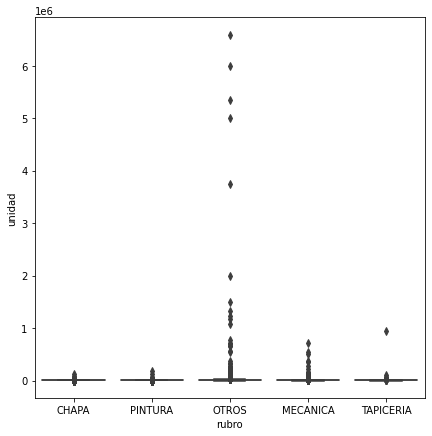

In [422]:
plt.figure(figsize = (7,7))
sns.boxplot('rubro', 'unidad', data = data_mo) 

C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rubro', ylabel='unidad'>

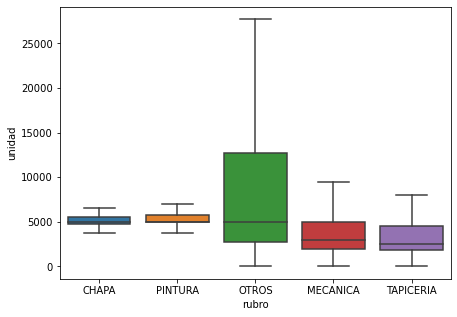

In [423]:
#Sacando outliers
plt.figure(figsize = (7,5))
sns.boxplot('rubro', 'unidad', data = data_mo, showfliers = False)

In [424]:
#Vamos a quitar la categoría OTROS ya que tiene mucha variabilidad (y suciedad por errores de carga)
data_mo_sinotros = data_mo[~data_mo['rubro'].str.contains('OTROS')]
data_mo_sinotros.rubro.value_counts()

CHAPA        14608
PINTURA      14010
MECANICA      1853
TAPICERIA      394
Name: rubro, dtype: int64

C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rubro', ylabel='unidad'>

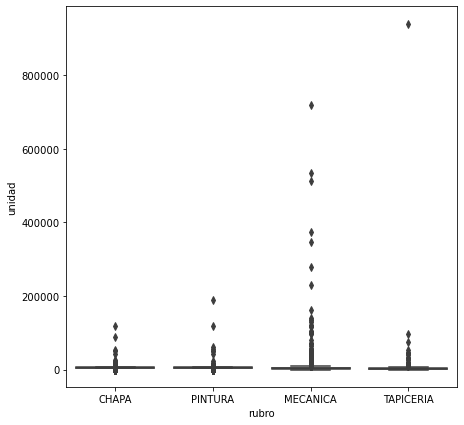

In [425]:
#Graficamos sin outliers
plt.figure(figsize = (7,7))
sns.boxplot('rubro', 'unidad', data = data_mo_sinotros) #, showfliers = False)

Observando la distribucion anterior, haremos un filtro en el dataframe y nos quedaremos con los registros que tengan valores de chapa y pintura que se encuentren entre $4000-7000. Los valores fuera de este rango se deben ppalmente a errores de carga. 

In [426]:
data_mo_clean = data_mo_sinotros[(data_mo_sinotros['unidad']>=3000) & (data_mo_sinotros['unidad']<=10000)]

In [427]:
print('Q_registros inicial:', data_mo.shape[0])
print('Q_registros sin categoría OTROS:', data_mo_sinotros.shape[0])
print('Q_registros final:', data_mo_clean.shape[0])
print('Q_registros decartados:', data_mo.shape[0]-data_mo_clean.shape[0])

Q_registros inicial: 33082
Q_registros sin categoría OTROS: 30865
Q_registros final: 29026
Q_registros decartados: 4056


C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rubro', ylabel='unidad'>

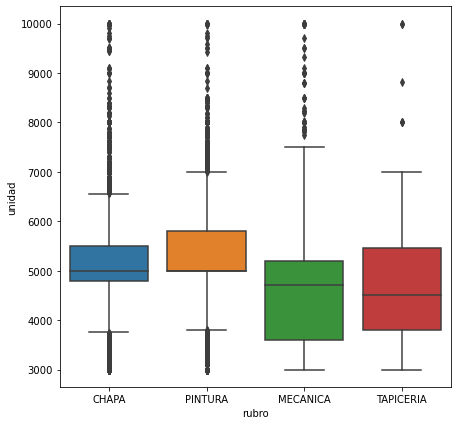

In [428]:
plt.figure(figsize = (7,7))
sns.boxplot('rubro', 'unidad', data = data_mo_clean)

In [429]:
data_mo_clean.groupby(['rubro'])['unidad'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
rubro,,,,,,,,
CHAPA,14203.0,5106.60,745.07,3000.0,4800.0,5000.00,5500.00,10000.0
MECANICA,904.0,4748.94,1456.21,3000.0,3600.0,4716.88,5200.00,10000.0
PINTURA,13778.0,5358.81,755.60,3000.0,5000.0,5000.00,5800.00,10000.0
TAPICERIA,141.0,4714.59,1349.08,3000.0,3800.0,4500.00,5455.05,10000.0


In [430]:
data_mo_clean.shape

(29026, 11)

In [431]:
data_mo_clean.rubro.value_counts()

CHAPA        14203
PINTURA      13778
MECANICA       904
TAPICERIA      141
Name: rubro, dtype: int64

Vemos cómo quedó el dataframe final luego del preprocessing

In [432]:
data_mo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29026 entries, 4 to 61299
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID_Tasacion  29026 non-null  int64  
 1   UOP          29026 non-null  int64  
 2   SUO          29026 non-null  int64  
 3   resultado    29026 non-null  object 
 4   tipo         29026 non-null  object 
 5   marca        29026 non-null  object 
 6   anio         29026 non-null  int64  
 7   rubro        29026 non-null  object 
 8   cantidad     29026 non-null  float64
 9   desvio       29026 non-null  float64
 10  unidad       29026 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 3.9+ MB


Se quitan de la variable 'resultado' las categorías que no suman info:

In [433]:
data_mo_clean.resultado.value_counts()

REPARAR                  21894
FRANQUICIA                2001
OTRO                      1975
DT                        1386
INDEMNIZAR                1355
INDEMNIZAR-MANO-OBRA       274
REPARAR-SIN-REPUESTOS       97
NO-APLICA                   22
FRAUDE                      22
Name: resultado, dtype: int64

In [434]:
lista_resultados = ['REPARAR', 'REPARAR-SIN-REPUESTOS', 'INDEMNIZAR', 'INDEMNIZAR-MANO-OBRA']

In [435]:
data_mo_clean = data_mo_clean[data_mo_clean['resultado'].isin(lista_resultados)]
data_mo_clean.resultado.value_counts()

REPARAR                  21894
INDEMNIZAR                1355
INDEMNIZAR-MANO-OBRA       274
REPARAR-SIN-REPUESTOS       97
Name: resultado, dtype: int64

In [436]:
data_mo_clean.shape

(23620, 11)

Se prepara el DF para dejar un solo registro (ID_Tasacion) por fila. El ID_tasacion lo utilizaremos para mergear con los otros DF.

In [437]:
index_columns = ['ID_Tasacion', 'UOP', 'SUO', 'resultado', 'tipo','anio', 'marca']
data_mo_final = pd.pivot_table(data_mo_clean, values=['cantidad', 'desvio'], index=index_columns,
                columns=['rubro'], aggfunc={'cantidad': np.sum, 'desvio': np.sum}, fill_value=0)
data_mo_final.head(3)

cantidad                   \
rubro                                              CHAPA MECANICA PINTURA   
ID_Tasacion UOP SUO resultado tipo anio marca                               
4819        3   338 REPARAR   AUTO 2015 NISSAN       6.0      0.0     6.5   
4820        2   246 REPARAR   AUTO 2018 RENAULT      0.5      0.0     0.5   
4821        3   338 REPARAR   AUTO 2015 RENAULT      3.5      0.0     4.0   

                                                          desvio           \
rubro                                           TAPICERIA  CHAPA MECANICA   
ID_Tasacion UOP SUO resultado tipo anio marca                               
4819        3   338 REPARAR   AUTO 2015 NISSAN        0.0    0.0        0   
4820        2   246 REPARAR   AUTO 2018 RENAULT       0.0    0.0        0   
4821        3   338 REPARAR   AUTO 2015 RENAULT       0.0   -0.5        0   

                                                                   
rubro                                           PINTURA TAPICERIA  
ID_Tasacion UOP SUO resultado tipo anio marca                      
4819        3   338 REPARAR   AUTO 2015 NISSAN      0.0         0  
4820        2   246 REPARAR   AUTO 2018 RENAULT     0.0         0  
4821        3   338 REPARAR   AUTO 2015 RENAULT    -0.5         0

In [438]:
data_mo_final.reset_index(inplace=True)

In [439]:
data_mo_final.columns = map("_".join, data_mo_final.columns)
data_mo_final.columns

Index(['ID_Tasacion_', 'UOP_', 'SUO_', 'resultado_', 'tipo_', 'anio_',
       'marca_', 'cantidad_CHAPA', 'cantidad_MECANICA', 'cantidad_PINTURA',
       'cantidad_TAPICERIA', 'desvio_CHAPA', 'desvio_MECANICA',
       'desvio_PINTURA', 'desvio_TAPICERIA'],
      dtype='object')

In [440]:
data_mo_final.rename(columns={'ID_Tasacion_':'ID_Tasacion'}, inplace=True)

Convertimos las variables UOP, SUO y anio_ a string para luego pasar todas a dummys

In [441]:
data_mo_final.loc[:,['UOP_','SUO_','anio_']] = data_mo_final.loc[:,['UOP_','SUO_','anio_']].astype(str)

In [442]:
data_mo_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11903 entries, 0 to 11902
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Tasacion         11903 non-null  int64  
 1   UOP_                11903 non-null  object 
 2   SUO_                11903 non-null  object 
 3   resultado_          11903 non-null  object 
 4   tipo_               11903 non-null  object 
 5   anio_               11903 non-null  object 
 6   marca_              11903 non-null  object 
 7   cantidad_CHAPA      11903 non-null  float64
 8   cantidad_MECANICA   11903 non-null  float64
 9   cantidad_PINTURA    11903 non-null  float64
 10  cantidad_TAPICERIA  11903 non-null  float64
 11  desvio_CHAPA        11903 non-null  float64
 12  desvio_MECANICA     11903 non-null  int64  
 13  desvio_PINTURA      11903 non-null  float64
 14  desvio_TAPICERIA    11903 non-null  int64  
dtypes: float64(6), int64(3), object(6)
memory usage: 1.4+

In [443]:
data_mo_final = pd.get_dummies(data_mo_final)

In [444]:
data_mo_final.head()

,ID_Tasacion,cantidad_CHAPA,cantidad_MECANICA,cantidad_PINTURA,cantidad_TAPICERIA,desvio_CHAPA,desvio_MECANICA,desvio_PINTURA,desvio_TAPICERIA,UOP__1,UOP__2,UOP__3,SUO__101,SUO__103,SUO__104,SUO__105,SUO__106,SUO__107,SUO__109,SUO__110,SUO__119,SUO__201,SUO__205,SUO__209,SUO__214,SUO__216,SUO__218,SUO__220,SUO__225,SUO__229,SUO__230,SUO__231,SUO__232,SUO__233,SUO__234,SUO__237,SUO__238,SUO__239,SUO__240,SUO__241,SUO__242,SUO__243,SUO__244,SUO__245,SUO__246,SUO__247,SUO__302,SUO__304,SUO__307,SUO__308,SUO__312,SUO__316,SUO__338,SUO__343,SUO__345,SUO__350,SUO__351,SUO__363,SUO__366,SUO__367,SUO__372,SUO__374,SUO__378,SUO__384,SUO__386,SUO__388,SUO__390,SUO__392,SUO__397,SUO__399,resultado__INDEMNIZAR,resultado__INDEMNIZAR-MANO-OBRA,resultado__REPARAR,resultado__REPARAR-SIN-REPUESTOS,tipo__4X4,tipo__AUTO,tipo__CAMION,tipo__PICKUP,tipo__SEMI-ACOPL,anio__1992,anio__1996,anio__1997,anio__1998,anio__1999,anio__2000,anio__2001,anio__2002,anio__2003,anio__2004,anio__2005,anio__2006,anio__2007,anio__2008,anio__2009,anio__2010,anio__2011,anio__2012,anio__2013,anio__2014,anio__2015,anio__2016,anio__2017,anio__2018,anio__2019,anio__2020,anio__2021,marca__ALFA ROMEO,marca__AUDI,marca__BMW,marca__CHERY,marca__CHEVROLET,marca__CHRYSLER,marca__CITROEN,marca__DFSK,marca__DODGE,marca__DS AUTIMOV,marca__FIAT,marca__FORD,marca__GEELY,marca__GREAT WALL,marca__HAVAL,marca__HINO,marca__HONDA,marca__HYUNDAI,marca__IVECO,marca__JAGUAR,marca__KIA,marca__LAND ROVER,marca__LIFAN,marca__MERC.BENZ,marca__MINICOOPER,marca__MITSUBISHI,marca__NISSAN,marca__PEUGEOT,marca__PORSCHE,marca__RENAULT,marca__SALTO,marca__SCANIA,marca__SMART,marca__SUBARU,marca__SUZUKI,marca__TOYOTA,marca__VOLKSWAGEN,marca__VOLVO
0,4819,6.0,0.0,6.5,0.0,0.0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,4820,0.5,0.0,0.5,0.0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4821,3.5,0.0,4.0,0.0,-0.5,0,-0.5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,4823,4.0,0.0,3.0,0.0,-1.5,0,-2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4827,0.0,0.0,2.0,0.0,0.0,0,-7.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [445]:
data_mo_final.shape

(11903, 144)

##### PREPOCESAMIENTO DB2: REPUESTOS

In [446]:
data_raw_rep = pd.read_csv('./Data_raw/Costo_repuestos_por_carpeta.csv', sep=';')
data_raw_rep.head(3)

,Stro,Carpeta,ID_Tasacion,HG,UO,SUO,Analista,PAS,Perito,resultado,accion,compulsa,id_compulsa,inspeccionado,tipo,marca,modelo,anio,cobertura,suma,id_parte,parte,calidad,grupo,Repuestero,precio,plazo
0,500961011631,2,16705,"DAÑO TOTAL, RC COSAS, RC LESIONES",1,101.0,ALVAREZ GASTON,"BARONE,FLORENCIA CARLA",FABIAN EDUARDO RAMON,DT,CAMBIAR,N,NaN,2021-06-03 00:00:00,AUTO,YAMAHA,150 FAZER FI,2018,DANOS-TOTALES,0.0,800164.0,PIEZA GENERICA 1,2,AUTOPARTE,GP MOTOS S.A.,49500.0,5.0
1,500961011631,2,16705,"DAÑO TOTAL, RC COSAS, RC LESIONES",1,101.0,ALVAREZ GASTON,"BARONE,FLORENCIA CARLA",FABIAN EDUARDO RAMON,DT,CAMBIAR,N,NaN,2021-06-03 00:00:00,AUTO,YAMAHA,150 FAZER FI,2018,DANOS-TOTALES,0.0,800165.0,PIEZA GENERICA 2,2,AUTOPARTE,GP MOTOS S.A.,38700.0,5.0
2,500961011631,2,16705,"DAÑO TOTAL, RC COSAS, RC LESIONES",1,101.0,ALVAREZ GASTON,"BARONE,FLORENCIA CARLA",FABIAN EDUARDO RAMON,DT,CAMBIAR,N,NaN,2021-06-03 00:00:00,AUTO,YAMAHA,150 FAZER FI,2018,DANOS-TOTALES,0.0,800166.0,PIEZA GENERICA 3,2,AUTOPARTE,GP MOTOS S.A.,67800.0,5.0


In [447]:
data_rep = data_raw_rep.copy()

In [448]:
data_rep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169568 entries, 0 to 169567
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Stro           169568 non-null  int64  
 1   Carpeta        169568 non-null  int64  
 2   ID_Tasacion    169568 non-null  int64  
 3   HG             169568 non-null  object 
 4   UO             169568 non-null  int64  
 5   SUO            155792 non-null  float64
 6   Analista       169568 non-null  object 
 7   PAS            169568 non-null  object 
 8   Perito         169568 non-null  object 
 9   resultado      169568 non-null  object 
 10  accion         165377 non-null  object 
 11  compulsa       168259 non-null  object 
 12  id_compulsa    31593 non-null   float64
 13  inspeccionado  169568 non-null  object 
 14  tipo           169568 non-null  object 
 15  marca          169568 non-null  object 
 16  modelo         169568 non-null  object 
 17  anio           169568 non-nul

En lugar de eliminar todas las columnas que se repiten en DB1, se genera un nuevo DF con las columnas importantes. Se deja el campo ID_Tasacion ya que se utilizará para mergear los dataframe.

In [449]:
data_rep_basic = data_rep.loc[:, ['ID_Tasacion', 'marca', 'anio', 'suma', 'accion', 'compulsa', 'id_parte', 'parte', 'calidad', 'precio']]
data_rep_basic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169568 entries, 0 to 169567
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID_Tasacion  169568 non-null  int64  
 1   marca        169568 non-null  object 
 2   anio         169568 non-null  int64  
 3   suma         169568 non-null  float64
 4   accion       165377 non-null  object 
 5   compulsa     168259 non-null  object 
 6   id_parte     165377 non-null  float64
 7   parte        165377 non-null  object 
 8   calidad      165377 non-null  object 
 9   precio       165371 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 12.9+ MB


Chequeamos registros vacíos y eliminamos:

In [450]:
data_rep_basic.isna().sum()

ID_Tasacion       0
marca             0
anio              0
suma              0
accion         4191
compulsa       1309
id_parte       4191
parte          4191
calidad        4191
precio         4197
dtype: int64

In [451]:
data_rep_clean=data_rep_basic.dropna()

In [452]:
data_rep_clean.isna().sum()

ID_Tasacion    0
marca          0
anio           0
suma           0
accion         0
compulsa       0
id_parte       0
parte          0
calidad        0
precio         0
dtype: int64

Comenzamos visualizando las categorías de la variable calidad:

In [453]:
data_rep_clean.calidad.value_counts().sort_values(ascending=False)

1           54938
LEGITIMO    52518
2           27679
0           16092
3           12680
4             183
Name: calidad, dtype: int64

Se genera un nuevo DF sin los registros con 'calidad'=LEGITIMO ya que por error de carga no tienen la referencia del precio (unidad). Tambien se quitan los registros con 'calidad'=0 ya que es una codifficación que significa 'indistinto' y no brinda informacion. 

In [454]:
data_rep_clean = data_rep_clean[(data_rep_clean['calidad']!='LEGITIMO') & (data_rep_clean['calidad']!='0')]

In [455]:
data_rep_clean.calidad.value_counts()

1    54938
2    27679
3    12680
4      183
Name: calidad, dtype: int64

In [456]:
data_rep_clean.shape

(95480, 10)

In [457]:
data_rep_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95480 entries, 0 to 169563
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID_Tasacion  95480 non-null  int64  
 1   marca        95480 non-null  object 
 2   anio         95480 non-null  int64  
 3   suma         95480 non-null  float64
 4   accion       95480 non-null  object 
 5   compulsa     95480 non-null  object 
 6   id_parte     95480 non-null  float64
 7   parte        95480 non-null  object 
 8   calidad      95480 non-null  object 
 9   precio       95480 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 8.0+ MB


Se verifica si existen registros de precio y suma con valor cero. Se borran tales registros.

In [458]:
data_rep_clean.precio[data_rep_clean.precio == 0].count()

79

In [459]:
data_rep_clean.drop(data_rep_clean[data_rep_clean.loc[:,'precio']==0].index, inplace=True)

In [460]:
data_rep_clean.precio[data_rep_clean.precio == 0].count()

0

In [461]:
data_rep_clean.suma[data_rep_clean.suma == 0].count()

25078

In [462]:
data_rep_clean.drop(data_rep_clean[data_rep_clean.loc[:,'suma']==0].index, inplace=True)

In [463]:
data_rep_clean.suma[data_rep_clean.suma == 0].count()

0

Creamos una nueva variable que relativiza el precio del repuesto (parte) a la suma asegurada (suma). La utilizaremos para segmentar los datos y categorizar los repuestos 

In [464]:
data_rep_clean['precio_SA'] = data_rep_clean['precio']/data_rep_clean['suma']
data_rep_clean['precio_SA'].head()

12    0.016592
24    0.041408
26    0.454545
27    0.454545
28    0.386364
Name: precio_SA, dtype: float64

In [465]:
data_rep_clean['precio_SA'].describe().round(4)
# Se observan valores de precio superiores a la SA (>1) --> Errores de carga que generan outliers

count    70323.0000
mean         0.0141
std          0.0264
min          0.0000
25%          0.0025
50%          0.0072
75%          0.0170
max          1.4689
Name: precio_SA, dtype: float64

C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


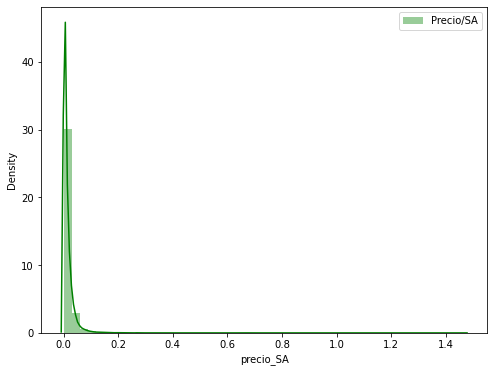

In [466]:
# Visualizamos la distribucion de la variable precio_SA
plt.figure(figsize=(8,6))
ax1 = sns.distplot(data_rep_clean.loc[:,'precio_SA'], label='Precio/SA', color="green")
plt.legend()
plt.show()

C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='calidad', ylabel='precio_SA'>

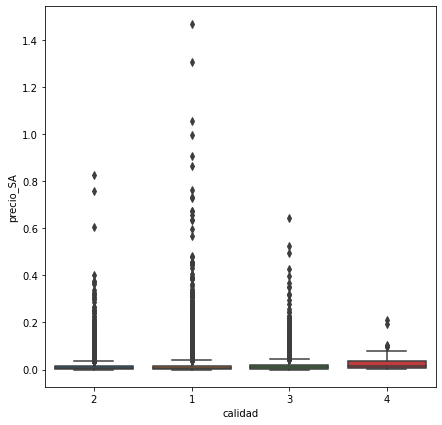

In [467]:
# Visualizamos segmentando por calidad. Se observa que el ppal error de carga está en la calidad=1
plt.figure(figsize = (7,7))
sns.boxplot('calidad', 'precio_SA', data = data_rep_clean)

In [468]:
#Se calculan los limites para la limpieza de datos
iqr = data_rep_clean.precio_SA.quantile(0.75) - data_rep_clean.precio_SA.quantile(0.25)

lim_sup = data_rep_clean.precio_SA.quantile(0.75) + 1.5 * iqr
print('Limite superior para limpieza de outliers:', lim_sup)

lim_inf = data_rep_clean.precio_SA.quantile(0.25) - 1.5 * iqr
print('Limite inferior para limpieza de outliers:', lim_inf)

Limite superior para limpieza de outliers: 0.03868576400098356
Limite inferior para limpieza de outliers: -0.019257336919705905


In [469]:
data_rep_clean = data_rep_clean[data_rep_clean.loc[:,'precio_SA']<=lim_sup]
data_rep_clean.shape

(65233, 11)

El limite inferior es negativo y por ende se deja en cero. Sin embargo, se detectan errores de carga en el precio de las partes. Como no es posible distinguir errores de valores verdaderos, se adopta el criterio de filtrar todos aquellos registros con precio menor a $200.

In [470]:
data_rep_clean.parte[data_rep_clean.loc[:,'precio']<=200].count()

1349

In [471]:
data_rep_clean.drop(data_rep_clean[data_rep_clean.loc[:,'precio']<=200].index, inplace=True)
data_rep_clean.shape

(63884, 11)

Se realiza análisis para intentar categorizar a cada uno de los repuestos, según su orden de importancia en el valor del vehículo. Se seleccionan sólo repuestos calidad_1 (originales) para disminuir la dispersion de precios dentro de una misma parte.

Se realiza previamente un breve análisis exploratorio de la variable parte.

In [472]:
print('Se identifican',data_rep_clean.parte.value_counts().count(), 'partes distintas')
data_rep_clean.parte.value_counts(normalize=True).round(4)*100

Se identifican 4455 partes distintas


PARAGOLPE DELANTERO                                     5.08
PARAGOLPE TRASERO                                       2.67
GUIA DE PARAGOLPES DER                                  2.44
GUIA DE PARAGOLPES IZQ                                  2.43
GUARDABARRO DI                                          1.66
                                                        ... 
CALCO DE PARANTE NEGRO PUERTA DI                        0.00
MOLDURA LAT DER DE REJILLA INF DE PARAGOLPES            0.00
LAVA OPTICA DERECHA                                     0.00
MOLDULO DE AIRBAG                                       0.00
BASE/SOPORTE INTERIOR DE MANIJA DE PUERTA TRAS. IZQ.    0.00
Name: parte, Length: 4455, dtype: float64

In [473]:
bar_count = pd.DataFrame({'count' : data_rep_clean.groupby( ['parte'] ).size()}).reset_index().sort_values(by='count', ascending=False)
bar_count.head()

,parte,count
2915,PARAGOLPE DELANTERO,3243
2934,PARAGOLPE TRASERO,1708
1768,GUIA DE PARAGOLPES DER,1561
1769,GUIA DE PARAGOLPES IZQ,1555
1683,GUARDABARRO DI,1058


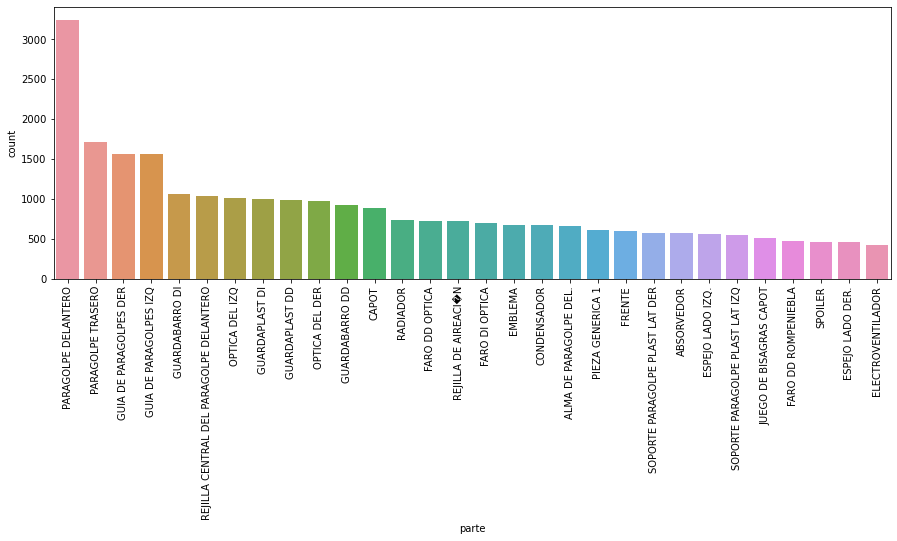

In [474]:
plt.figure(figsize = (15,5))
sns.barplot(x='parte',y='count', data=bar_count.head(30)).tick_params(axis='x', rotation=90)

In [475]:
#Vemos algunas estadisticas del paragolpe
data_rep_clean[data_rep_clean['parte'].str.contains('PARAGOLPE')].groupby('parte').agg(
              {'precio':['count','min','max','mean','median','std']}).sort_values([('precio', 'count')],ascending=False)

precio                       \
                                                   count       min        max   
parte                                                                           
PARAGOLPE DELANTERO                                 3243    590.00  419890.67   
PARAGOLPE TRASERO                                   1708   1530.55  300519.00   
GUIA DE PARAGOLPES DER                              1561    202.47  157300.00   
GUIA DE PARAGOLPES IZQ                              1555    205.00   43984.29   
REJILLA CENTRAL DEL PARAGOLPE DELANTERO             1034    289.00  134700.00   
...                                                  ...       ...        ...   
MOLDURA INF. CIEGA PARAGOLPE DEL. LADO IZQ.            1   1100.00    1100.00   
MOLDURA GRIS CENTRAL DE PARAGOLPES DELANTERO           1  17566.00   17566.00   
MOLDURA GRIS BAJO REJILLA INFERIOR PARAGOLPE DEL.      1  12900.00   12900.00   
MOLDURA FENDER NEGRA DE PARAGOLPE GUARD. DEL DER       1  16728.00   16728.00   
VIRA DE PARAGOLPE TRASERO                              1   5900.00    5900.00   

                                                                           \
                                                           mean    median   
parte                                                                       
PARAGOLPE DELANTERO                                24167.635011  20093.00   
PARAGOLPE TRASERO                                  25516.209988  20914.50   
GUIA DE PARAGOLPES DER                              2225.988187   1419.52   
GUIA DE PARAGOLPES IZQ                              1990.211273   1427.27   
REJILLA CENTRAL DEL PARAGOLPE DELANTERO            10659.323240   6735.61   
...                                                         ...       ...   
MOLDURA INF. CIEGA PARAGOLPE DEL. LADO IZQ.         1100.000000   1100.00   
MOLDURA GRIS CENTRAL DE PARAGOLPES DELANTERO       17566.000000  17566.00   
MOLDURA GRIS BAJO REJILLA INFERIOR PARAGOLPE DEL.  12900.000000  12900.00   
MOLDURA FENDER NEGRA DE PARAGOLPE GUARD. DEL DER   16728.000000  16728.00   
VIRA DE PARAGOLPE TRASERO                           5900.000000   5900.00   

                                                                 
                                                            std  
parte                                                            
PARAGOLPE DELANTERO                                21723.766689  
PARAGOLPE TRASERO                                  20948.952305  
GUIA DE PARAGOLPES DER                              5354.599631  
GUIA DE PARAGOLPES IZQ                              2402.879055  
REJILLA CENTRAL DEL PARAGOLPE DELANTERO            13424.462819  
...                                                         ...  
MOLDURA INF. CIEGA PARAGOLPE DEL. LADO IZQ.                 NaN  
MOLDURA GRIS CENTRAL DE PARAGOLPES DELANTERO                NaN  
MOLDURA GRIS BAJO REJILLA INFERIOR PARAGOLPE DEL.           NaN  
MOLDURA FENDER NEGRA DE PARAGOLPE GUARD. DEL DER            NaN  
VIRA DE PARAGOLPE TRASERO                                   NaN  

[597 rows x 6 columns]

In [476]:
data_rep_clean.columns

Index(['ID_Tasacion', 'marca', 'anio', 'suma', 'accion', 'compulsa',
       'id_parte', 'parte', 'calidad', 'precio', 'precio_SA'],
      dtype='object')

In [477]:
data_rep_clean = data_rep_clean.reset_index(drop=True)

In [478]:
data_rep_clean.shape

(63884, 11)

In [479]:
data_rep_clean.head()

,ID_Tasacion,marca,anio,suma,accion,compulsa,id_parte,parte,calidad,precio,precio_SA
0,13323,FORD,2010,396000.0,CAMBIAR,S,1244.0,REJILLA INFERIOR IZQUIERDA,2,6570.25,0.016592
1,9856,VOLKSWAGEN,2017,1540000.0,CAMBIAR,S,110660.0,CALCO PARANTE,2,2820.00,0.001831
2,10856,FORD,2014,314000.0,CAMBIAR,N,453.0,GUARDAPLAST DD,2,10009.00,0.031876
3,10856,FORD,2014,314000.0,CAMBIAR,N,1014.0,RULEMAN PORTAMAZA,2,10867.00,0.034608
4,10856,FORD,2014,314000.0,CAMBIAR,N,632.0,MASCARA FRENTE,2,11570.00,0.036847


In [480]:
data_rep_calidad1 = data_rep_clean[data_rep_clean.loc[:,'calidad']=='1']

In [481]:
data_rep_calidad1.sample(5)

,ID_Tasacion,marca,anio,suma,accion,compulsa,id_parte,parte,calidad,precio,precio_SA
30080,7280,TOYOTA,2018,3080000.0,CAMBIAR,N,360.0,ESTRIBERO DE PARAGOLPE,1,13389.00,0.004347
49580,35254,TOYOTA,2012,2135700.0,CAMBIAR,S,403.0,FARO TD EXTERIOR,1,6357.16,0.002977
11239,26970,FIAT,2012,675400.0,CAMBIAR,N,798.0,OPTICA DEL IZQ,1,21900.00,0.032425
11973,22277,TOYOTA,2011,1630000.0,CAMBIAR,S,899.0,PISADERO CENTRAL PARAGOLPE TRAS,1,4920.00,0.003018
58279,28297,CITROEN,2014,1104500.0,CAMBIAR,N,448.0,GUARDABARRO DD,1,14050.00,0.012721


C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


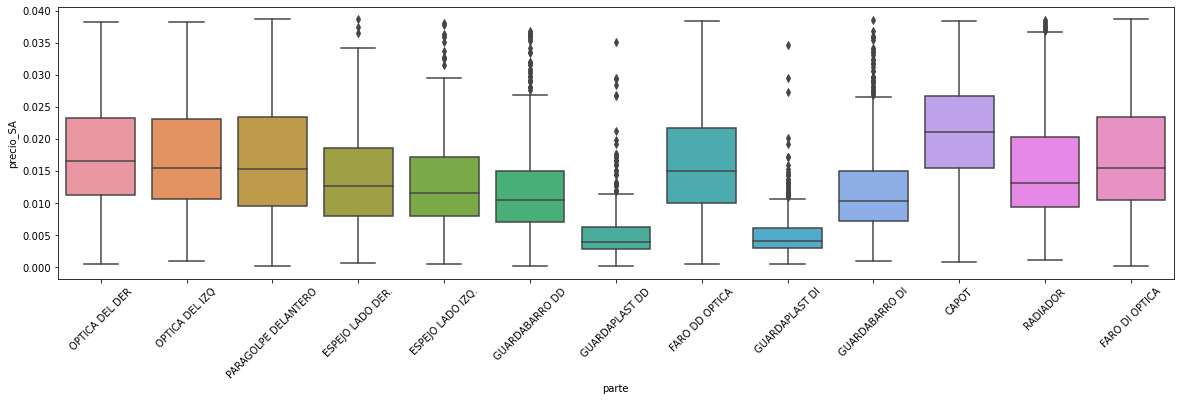

In [586]:
list_partes = ['PARAGOLPE DELANTERO', 'GUARDABARRO DI', 'GUARDABARRO DD', 'GUARDAPLAST DI', 'GUARDAPLAST DD', 'OPTICA DEL IZQ', 'OPTICA DEL DER', 'CAPOT', 'RADIADOR', 'FARO DD OPTICA', 'FARO DI OPTICA', 'ESPEJO LADO IZQ.', 'ESPEJO LADO DER.']
plt.figure(figsize = (20,5))
sns.boxplot('parte','precio_SA', data = data_rep_calidad1[data_rep_calidad1.loc[:,'parte'].isin(list_partes)]).tick_params(axis='x', rotation=45)

In [587]:
print('Q_registros:', data_rep_calidad1.shape[0])

Q_registros: 38487


In [588]:
print('Q_partes_distintas:', data_rep_calidad1.parte.nunique())

Q_partes_distintas: 2076


Al tomar solo calidad original se pierden la mitad de partes (y quedarán sin categorizar). A partir de esto, se opta por tomar todo el universo disponible y se asume el error. Luego se intentará conseguir a traves del proveedor un mayor volumen de datos para poder realizar la segmentacion.

Se genera un DF con la media de precio_SA para cada parte. Dicho DF se utiliza para segmentar y categorizar.

In [484]:
partes_mean = pd.DataFrame({'mean' : data_rep_clean.groupby('parte')['precio_SA'].agg('mean')}).reset_index()
print('shape:', partes_mean.shape)
partes_mean.head()

shape: (4455, 2)


,parte,mean
0,"""1 LLANTA CHAPA DI ROD 14\t""",0.004836
1,-INSIGNIA CITY DE TAPA DE BAÚL.,0.002082
2,-INSIGNIA I-VTEC DE TAPA DE BAÚL.,0.002701
3,1 APOYO REGULABLE DE CAPOT,0.000723
4,1 CUBIERTA GOOD YEAR PERFORMANCE 205 / 55 / R17,0.012116


In [554]:
partes_mean['categoria_parte'] = pd.qcut(partes_mean['mean'],q=[0, .25, .5, .75, 1.], labels=['C1', 'C2', 'C3', 'C4'])
partes_mean['categoria_parte'].value_counts()

C4    1114
C2    1114
C1    1114
C3    1113
Name: categoria_parte, dtype: int64

In [555]:
partes_mean.head()

,parte,mean,categoria_parte
0,"""1 LLANTA CHAPA DI ROD 14\t""",0.004836,C3
1,-INSIGNIA CITY DE TAPA DE BAÚL.,0.002082,C2
2,-INSIGNIA I-VTEC DE TAPA DE BAÚL.,0.002701,C2
3,1 APOYO REGULABLE DE CAPOT,0.000723,C1
4,1 CUBIERTA GOOD YEAR PERFORMANCE 205 / 55 / R17,0.012116,C4


Veamos cómo quedaron distribuidos los datos dentro de cada categoria:

C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='categoria_parte', ylabel='mean'>

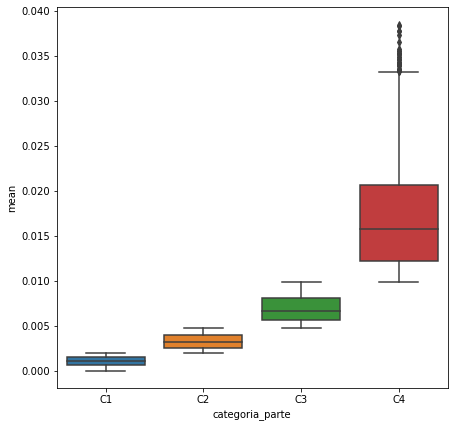

In [556]:
plt.figure(figsize = (7,7))
sns.boxplot('categoria_parte', 'mean', data = partes_mean)

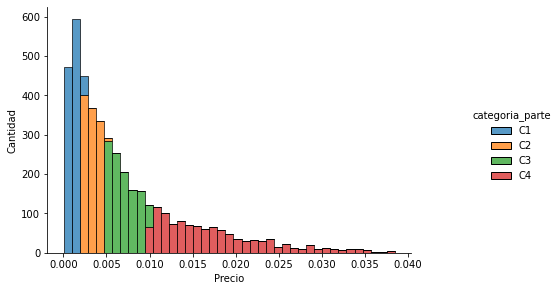

In [594]:
g = sns.displot(data=partes_mean, x="mean", hue="categoria_parte", multiple="stack", stat="count")
g.fig.set_size_inches(8, 4)
g.set_axis_labels("Precio", "Cantidad")
plt.show()

In [607]:
print('Vemos como se va ampliando el rango:')
print('Q1:', partes_mean['mean'].quantile(.25).round(4), ', Rango:', (partes_mean['mean'].quantile(.25)-partes_mean['mean'].quantile(.0)).round(4))
print('Q2:', partes_mean['mean'].quantile(.5).round(4), ', Rango:', (partes_mean['mean'].quantile(.5)-partes_mean['mean'].quantile(.25)).round(4))
print('Q3:', partes_mean['mean'].quantile(.75).round(4), ', Rango:', (partes_mean['mean'].quantile(.75)-partes_mean['mean'].quantile(.5)).round(4))
print('Q4:', partes_mean['mean'].quantile(1.).round(4), ', Rango:', (partes_mean['mean'].quantile(1.)-partes_mean['mean'].quantile(.75)).round(4))

Vemos como se va ampliando el rango:
Q1: 0.002 , Rango: 0.002
Q2: 0.0048 , Rango: 0.0027
Q3: 0.0099 , Rango: 0.0051
Q4: 0.0385 , Rango: 0.0286


Se observa en el histograma (al igual que en el boxplot) que a medida que incrementa el precio relativo a la suma, encontramos mayor variabilidad por categoría. Si miramos el barplot y boxplot por repuesto de más arriba, vemos que los repuestos que más se repiten caen dentro de la C4 (ouch!). Tendremos que hacer una nueva y diferente segmentacion.

In [ ]:
pd.qcut(partes_mean['mean']

Dentro de C4 seguimos teniendo mucha amplitud. Vamos a asignar las categorias a cada repuesto del dataset y veamos qué cantidad de datos caen en cada una.

In [557]:
data_rep_cat = pd.merge(data_rep_clean, partes_mean, on=['parte'], how='inner')

In [558]:
data_rep_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63884 entries, 0 to 63883
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID_Tasacion      63884 non-null  int64   
 1   marca            63884 non-null  object  
 2   anio             63884 non-null  int64   
 3   suma             63884 non-null  float64 
 4   accion           63884 non-null  object  
 5   compulsa         63884 non-null  object  
 6   id_parte         63884 non-null  float64 
 7   parte            63884 non-null  object  
 8   calidad          63884 non-null  object  
 9   precio           63884 non-null  float64 
 10  precio_SA        63884 non-null  float64 
 11  mean             63884 non-null  float64 
 12  categoria_parte  63884 non-null  category
dtypes: category(1), float64(5), int64(2), object(5)
memory usage: 6.4+ MB


In [559]:
data_rep_cat.head()

,ID_Tasacion,marca,anio,suma,accion,compulsa,id_parte,parte,calidad,precio,precio_SA,mean,categoria_parte
0,13323,FORD,2010,396000.0,CAMBIAR,S,1244.0,REJILLA INFERIOR IZQUIERDA,2,6570.25,0.016592,0.003035,C2
1,26513,CITROEN,2015,449500.0,CAMBIAR,N,1244.0,REJILLA INFERIOR IZQUIERDA,1,14584.75,0.032447,0.003035,C2
2,24727,HONDA,2017,1804800.0,CAMBIAR,N,1244.0,REJILLA INFERIOR IZQUIERDA,1,627.27,0.000348,0.003035,C2
3,5821,HONDA,2018,2222000.0,CAMBIAR,N,1244.0,REJILLA INFERIOR IZQUIERDA,1,4800.00,0.002160,0.003035,C2
4,26687,HONDA,2018,2222000.0,CAMBIAR,N,1244.0,REJILLA INFERIOR IZQUIERDA,1,4800.00,0.002160,0.003035,C2


In [560]:
data_rep_cat.categoria_parte.value_counts()

# Estan desbalanceadas debido a que los repuestos más cambiados son de las categorías más caras.

C4    27292
C3    19148
C2     9820
C1     7624
Name: categoria_parte, dtype: int64

Debido a que la categorizacion de cada parte se realizó a partir de su precio medio, veamos cuán puros están los grupos: 

Generamos un DF de con la variable compulsa, que utilizaremos más adelante para mergear.

In [490]:
data_rep_compulsa = data_rep_cat.loc[:,['ID_Tasacion','compulsa']]
data_rep_compulsa.head()

,ID_Tasacion,compulsa
0,13323,S
1,26513,N
2,24727,N
3,5821,N
4,26687,N


In [491]:
data_rep_compulsa = data_rep_compulsa.sort_values(by=['ID_Tasacion'], ascending=True).drop_duplicates(subset=['ID_Tasacion'], keep='last').reset_index(drop=True)

In [492]:
data_rep_compulsa=pd.get_dummies(data_rep_compulsa)
data_rep_compulsa.head()

,ID_Tasacion,compulsa_N,compulsa_S
0,4818,1,0
1,4819,0,1
2,4820,0,1
3,4821,1,0
4,4822,0,1


In [493]:
data_rep_compulsa.shape

(11338, 3)

Se prepara el DF para dejar un solo registro (ID_Tasacion) por fila:

In [494]:
data_rep_cambiar = pd.pivot_table(data_rep_cat[data_rep_cat.loc[:,'accion']=='CAMBIAR'], values=['parte'], index=['ID_Tasacion'],
                columns=['calidad','categoria_parte'], aggfunc={'parte':'count'}, fill_value=0)
data_rep_cambiar.head()

parte                                                         \
calidad             1                              2                           
categoria_parte    C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 C1 C2 C3 C4 C5 C6 C7 C8 C9   
ID_Tasacion                                                                    
4818                0  2  0  0  3  4  1  3  7   3  0  0  0  0  0  0  0  0  0   
4819                0  2  0  0  0  0  0  2  0   0  0  0  0  0  0  0  0  0  0   
4820                0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  1   
4821                0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  2  0  2   
4822                0  0  0  0  0  0  0  2  0   0  0  0  0  0  0  0  0  0  0   

                                                                               \
calidad              3                              4                           
categoria_parte C10 C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 C1 C2 C3 C4 C5 C6 C7 C8 C9   
ID_Tasacion                                                                     
4818              0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0   
4819              0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0   
4820              0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0   
4821              0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0   
4822              0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0  0  0   

                     
calidad              
categoria_parte C10  
ID_Tasacion          
4818              0  
4819              0  
4820              0  
4821              0  
4822              0

In [495]:
data_rep_cambiar.rename(columns={'parte':'Q_repuestos'}, level=0, inplace=True)
data_rep_cambiar.head()

Q_repuestos                                                   \
calidad                   1                              2                     
categoria_parte          C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 C1 C2 C3 C4 C5 C6 C7   
ID_Tasacion                                                                    
4818                      0  2  0  0  3  4  1  3  7   3  0  0  0  0  0  0  0   
4819                      0  2  0  0  0  0  0  2  0   0  0  0  0  0  0  0  0   
4820                      0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0   
4821                      0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  2   
4822                      0  0  0  0  0  0  0  2  0   0  0  0  0  0  0  0  0   

                                                                               \
calidad                    3                              4                     
categoria_parte C8 C9 C10 C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 C1 C2 C3 C4 C5 C6 C7   
ID_Tasacion                                                                     
4818             0  0   0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0   
4819             0  0   0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0   
4820             0  1   0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0   
4821             0  2   0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0   
4822             0  0   0  0  0  0  0  0  0  0  0  0   0  0  0  0  0  0  0  0   

                           
calidad                    
categoria_parte C8 C9 C10  
ID_Tasacion                
4818             0  0   0  
4819             0  0   0  
4820             0  0   0  
4821             0  0   0  
4822             0  0   0

In [496]:
data_rep_cambiar.columns.levels[1]

Index(['1', '2', '3', '4'], dtype='object', name='calidad')

In [497]:
data_rep_cambiar.rename(columns={'1':'calidad_1', '2':'calidad_2', '3':'calidad_3', '4':'calidad_4'}, level=1, inplace=True)

In [498]:
data_rep_cambiar.columns.levels[1]

Index(['calidad_1', 'calidad_2', 'calidad_3', 'calidad_4'], dtype='object', name='calidad')

In [499]:
data_rep_cambiar.columns.levels[2]

Index(['C1', 'C10', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'], dtype='object', name='categoria_parte')

In [500]:
data_rep_cambiar.reset_index(inplace=True)

In [501]:
data_rep_cambiar.columns = map("_".join, data_rep_cambiar.columns)
data_rep_cambiar.columns

Index(['ID_Tasacion__', 'Q_repuestos_calidad_1_C1', 'Q_repuestos_calidad_1_C2',
       'Q_repuestos_calidad_1_C3', 'Q_repuestos_calidad_1_C4',
       'Q_repuestos_calidad_1_C5', 'Q_repuestos_calidad_1_C6',
       'Q_repuestos_calidad_1_C7', 'Q_repuestos_calidad_1_C8',
       'Q_repuestos_calidad_1_C9', 'Q_repuestos_calidad_1_C10',
       'Q_repuestos_calidad_2_C1', 'Q_repuestos_calidad_2_C2',
       'Q_repuestos_calidad_2_C3', 'Q_repuestos_calidad_2_C4',
       'Q_repuestos_calidad_2_C5', 'Q_repuestos_calidad_2_C6',
       'Q_repuestos_calidad_2_C7', 'Q_repuestos_calidad_2_C8',
       'Q_repuestos_calidad_2_C9', 'Q_repuestos_calidad_2_C10',
       'Q_repuestos_calidad_3_C1', 'Q_repuestos_calidad_3_C2',
       'Q_repuestos_calidad_3_C3', 'Q_repuestos_calidad_3_C4',
       'Q_repuestos_calidad_3_C5', 'Q_repuestos_calidad_3_C6',
       'Q_repuestos_calidad_3_C7', 'Q_repuestos_calidad_3_C8',
       'Q_repuestos_calidad_3_C9', 'Q_repuestos_calidad_3_C10',
       'Q_repuestos_calidad_4_C1', 

In [502]:
data_rep_cambiar.rename(columns={'ID_Tasacion__':'ID_Tasacion'}, inplace=True)

In [503]:
data_rep_cambiar.head()

,ID_Tasacion,Q_repuestos_calidad_1_C1,Q_repuestos_calidad_1_C2,Q_repuestos_calidad_1_C3,Q_repuestos_calidad_1_C4,Q_repuestos_calidad_1_C5,Q_repuestos_calidad_1_C6,Q_repuestos_calidad_1_C7,Q_repuestos_calidad_1_C8,Q_repuestos_calidad_1_C9,Q_repuestos_calidad_1_C10,Q_repuestos_calidad_2_C1,Q_repuestos_calidad_2_C2,Q_repuestos_calidad_2_C3,Q_repuestos_calidad_2_C4,Q_repuestos_calidad_2_C5,Q_repuestos_calidad_2_C6,Q_repuestos_calidad_2_C7,Q_repuestos_calidad_2_C8,Q_repuestos_calidad_2_C9,Q_repuestos_calidad_2_C10,Q_repuestos_calidad_3_C1,Q_repuestos_calidad_3_C2,Q_repuestos_calidad_3_C3,Q_repuestos_calidad_3_C4,Q_repuestos_calidad_3_C5,Q_repuestos_calidad_3_C6,Q_repuestos_calidad_3_C7,Q_repuestos_calidad_3_C8,Q_repuestos_calidad_3_C9,Q_repuestos_calidad_3_C10,Q_repuestos_calidad_4_C1,Q_repuestos_calidad_4_C2,Q_repuestos_calidad_4_C3,Q_repuestos_calidad_4_C4,Q_repuestos_calidad_4_C5,Q_repuestos_calidad_4_C6,Q_repuestos_calidad_4_C7,Q_repuestos_calidad_4_C8,Q_repuestos_calidad_4_C9,Q_repuestos_calidad_4_C10
0,4818,0,2,0,0,3,4,1,3,7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4819,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4821,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4822,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [504]:
data_rep_cambiar.shape

(11326, 41)

In [505]:
data_rep_cambiar_final = pd.merge(data_rep_cambiar, data_rep_compulsa, on=['ID_Tasacion'], how='inner')
data_rep_cambiar_final.head()

,ID_Tasacion,Q_repuestos_calidad_1_C1,Q_repuestos_calidad_1_C2,Q_repuestos_calidad_1_C3,Q_repuestos_calidad_1_C4,Q_repuestos_calidad_1_C5,Q_repuestos_calidad_1_C6,Q_repuestos_calidad_1_C7,Q_repuestos_calidad_1_C8,Q_repuestos_calidad_1_C9,Q_repuestos_calidad_1_C10,Q_repuestos_calidad_2_C1,Q_repuestos_calidad_2_C2,Q_repuestos_calidad_2_C3,Q_repuestos_calidad_2_C4,Q_repuestos_calidad_2_C5,Q_repuestos_calidad_2_C6,Q_repuestos_calidad_2_C7,Q_repuestos_calidad_2_C8,Q_repuestos_calidad_2_C9,Q_repuestos_calidad_2_C10,Q_repuestos_calidad_3_C1,Q_repuestos_calidad_3_C2,Q_repuestos_calidad_3_C3,Q_repuestos_calidad_3_C4,Q_repuestos_calidad_3_C5,Q_repuestos_calidad_3_C6,Q_repuestos_calidad_3_C7,Q_repuestos_calidad_3_C8,Q_repuestos_calidad_3_C9,Q_repuestos_calidad_3_C10,Q_repuestos_calidad_4_C1,Q_repuestos_calidad_4_C2,Q_repuestos_calidad_4_C3,Q_repuestos_calidad_4_C4,Q_repuestos_calidad_4_C5,Q_repuestos_calidad_4_C6,Q_repuestos_calidad_4_C7,Q_repuestos_calidad_4_C8,Q_repuestos_calidad_4_C9,Q_repuestos_calidad_4_C10,compulsa_N,compulsa_S
0,4818,0,2,0,0,3,4,1,3,7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4819,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,4820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4821,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4822,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [506]:
data_rep_cambiar_final.shape

(11326, 43)

Se genera un nuevo y ultimo DF de repuestos con la cantidad de partes reparadas por tasación. Se vuelve a tomar el DF de origen ya que se han ido eliminando registros que ahora nos interesan (calidad=LEGITIMO o precio=0).

In [507]:
data_rep_reparar=data_rep_basic.dropna()

In [508]:
data_rep_reparar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164090 entries, 0 to 169567
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID_Tasacion  164090 non-null  int64  
 1   marca        164090 non-null  object 
 2   anio         164090 non-null  int64  
 3   suma         164090 non-null  float64
 4   accion       164090 non-null  object 
 5   compulsa     164090 non-null  object 
 6   id_parte     164090 non-null  float64
 7   parte        164090 non-null  object 
 8   calidad      164090 non-null  object 
 9   precio       164090 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 13.8+ MB


In [509]:
print('Se registran', data_rep_reparar.parte.nunique(), 'repuestos unicos')

Se registran 4999 repuestos unicos


Asignamos las categorias que definimos antes a las partes:

In [510]:
data_rep_cat2 = pd.merge(data_rep_reparar, partes_mean, on=['parte'], how='inner')

In [511]:
data_rep_cat2.categoria_parte.value_counts()

C9     47530
C10    44387
C8     16748
C6     14743
C7     10842
C5      7616
C2      7438
C4      6113
C3      5617
C1       630
Name: categoria_parte, dtype: int64

Generamos el DF de cantidad de piezas reparadas por tasacion para luego mergearlo con el DF final:

In [512]:
data_rep_qreparar = pd.pivot_table(data_rep_cat2[data_rep_cat2.loc[:,'accion']=='REPARAR'], values=['parte'], index=['ID_Tasacion'],
                columns=['accion','categoria_parte'], aggfunc={'parte':'count'}, fill_value=0)

In [513]:
data_rep_qreparar.head()

parte                            
accion          REPARAR                            
categoria_parte      C1 C2 C3 C4 C5 C6 C7 C8 C9 C10
ID_Tasacion                                        
4815                  0  0  0  0  0  0  0  0  0   2
4816                  0  0  0  0  0  0  0  0  1   2
4817                  0  0  0  0  0  0  0  0  2   8
4818                  0  0  0  0  0  0  0  0  2   2
4819                  0  0  0  0  0  0  0  0  0   2

In [514]:
data_rep_qreparar.rename(columns={'parte':'Q_repuestos'}, level=0, inplace=True)

In [515]:
data_rep_qreparar.reset_index(inplace=True)

In [516]:
data_rep_qreparar.columns = map("_".join, data_rep_qreparar.columns)
data_rep_qreparar.columns

Index(['ID_Tasacion__', 'Q_repuestos_REPARAR_C1', 'Q_repuestos_REPARAR_C2',
       'Q_repuestos_REPARAR_C3', 'Q_repuestos_REPARAR_C4',
       'Q_repuestos_REPARAR_C5', 'Q_repuestos_REPARAR_C6',
       'Q_repuestos_REPARAR_C7', 'Q_repuestos_REPARAR_C8',
       'Q_repuestos_REPARAR_C9', 'Q_repuestos_REPARAR_C10'],
      dtype='object')

In [517]:
data_rep_qreparar.rename(columns={'ID_Tasacion__':'ID_Tasacion'}, inplace=True)

In [518]:
data_rep_qreparar.head()

,ID_Tasacion,Q_repuestos_REPARAR_C1,Q_repuestos_REPARAR_C2,Q_repuestos_REPARAR_C3,Q_repuestos_REPARAR_C4,Q_repuestos_REPARAR_C5,Q_repuestos_REPARAR_C6,Q_repuestos_REPARAR_C7,Q_repuestos_REPARAR_C8,Q_repuestos_REPARAR_C9,Q_repuestos_REPARAR_C10
0,4815,0,0,0,0,0,0,0,0,0,2
1,4816,0,0,0,0,0,0,0,0,1,2
2,4817,0,0,0,0,0,0,0,0,2,8
3,4818,0,0,0,0,0,0,0,0,2,2
4,4819,0,0,0,0,0,0,0,0,0,2


In [519]:
data_rep_qreparar.shape

(20015, 11)

Nos quedamos con 2 DF para mergear al de mano de obra.

In [520]:
data_repuestos_final = pd.merge(data_rep_cambiar_final, data_rep_qreparar, on=['ID_Tasacion'], how='outer')
print(data_repuestos_final.shape)
data_repuestos_final.head()

(22765, 53)


,ID_Tasacion,Q_repuestos_calidad_1_C1,Q_repuestos_calidad_1_C2,Q_repuestos_calidad_1_C3,Q_repuestos_calidad_1_C4,Q_repuestos_calidad_1_C5,Q_repuestos_calidad_1_C6,Q_repuestos_calidad_1_C7,Q_repuestos_calidad_1_C8,Q_repuestos_calidad_1_C9,Q_repuestos_calidad_1_C10,Q_repuestos_calidad_2_C1,Q_repuestos_calidad_2_C2,Q_repuestos_calidad_2_C3,Q_repuestos_calidad_2_C4,Q_repuestos_calidad_2_C5,Q_repuestos_calidad_2_C6,Q_repuestos_calidad_2_C7,Q_repuestos_calidad_2_C8,Q_repuestos_calidad_2_C9,Q_repuestos_calidad_2_C10,Q_repuestos_calidad_3_C1,Q_repuestos_calidad_3_C2,Q_repuestos_calidad_3_C3,Q_repuestos_calidad_3_C4,Q_repuestos_calidad_3_C5,Q_repuestos_calidad_3_C6,Q_repuestos_calidad_3_C7,Q_repuestos_calidad_3_C8,Q_repuestos_calidad_3_C9,Q_repuestos_calidad_3_C10,Q_repuestos_calidad_4_C1,Q_repuestos_calidad_4_C2,Q_repuestos_calidad_4_C3,Q_repuestos_calidad_4_C4,Q_repuestos_calidad_4_C5,Q_repuestos_calidad_4_C6,Q_repuestos_calidad_4_C7,Q_repuestos_calidad_4_C8,Q_repuestos_calidad_4_C9,Q_repuestos_calidad_4_C10,compulsa_N,compulsa_S,Q_repuestos_REPARAR_C1,Q_repuestos_REPARAR_C2,Q_repuestos_REPARAR_C3,Q_repuestos_REPARAR_C4,Q_repuestos_REPARAR_C5,Q_repuestos_REPARAR_C6,Q_repuestos_REPARAR_C7,Q_repuestos_REPARAR_C8,Q_repuestos_REPARAR_C9,Q_repuestos_REPARAR_C10
0,4818,0.0,2.0,0.0,0.0,3.0,4.0,1.0,3.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
1,4819,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,4820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0


In [521]:
data_repuestos_final=data_repuestos_final.fillna(0)
data_repuestos_final.head()

,ID_Tasacion,Q_repuestos_calidad_1_C1,Q_repuestos_calidad_1_C2,Q_repuestos_calidad_1_C3,Q_repuestos_calidad_1_C4,Q_repuestos_calidad_1_C5,Q_repuestos_calidad_1_C6,Q_repuestos_calidad_1_C7,Q_repuestos_calidad_1_C8,Q_repuestos_calidad_1_C9,Q_repuestos_calidad_1_C10,Q_repuestos_calidad_2_C1,Q_repuestos_calidad_2_C2,Q_repuestos_calidad_2_C3,Q_repuestos_calidad_2_C4,Q_repuestos_calidad_2_C5,Q_repuestos_calidad_2_C6,Q_repuestos_calidad_2_C7,Q_repuestos_calidad_2_C8,Q_repuestos_calidad_2_C9,Q_repuestos_calidad_2_C10,Q_repuestos_calidad_3_C1,Q_repuestos_calidad_3_C2,Q_repuestos_calidad_3_C3,Q_repuestos_calidad_3_C4,Q_repuestos_calidad_3_C5,Q_repuestos_calidad_3_C6,Q_repuestos_calidad_3_C7,Q_repuestos_calidad_3_C8,Q_repuestos_calidad_3_C9,Q_repuestos_calidad_3_C10,Q_repuestos_calidad_4_C1,Q_repuestos_calidad_4_C2,Q_repuestos_calidad_4_C3,Q_repuestos_calidad_4_C4,Q_repuestos_calidad_4_C5,Q_repuestos_calidad_4_C6,Q_repuestos_calidad_4_C7,Q_repuestos_calidad_4_C8,Q_repuestos_calidad_4_C9,Q_repuestos_calidad_4_C10,compulsa_N,compulsa_S,Q_repuestos_REPARAR_C1,Q_repuestos_REPARAR_C2,Q_repuestos_REPARAR_C3,Q_repuestos_REPARAR_C4,Q_repuestos_REPARAR_C5,Q_repuestos_REPARAR_C6,Q_repuestos_REPARAR_C7,Q_repuestos_REPARAR_C8,Q_repuestos_REPARAR_C9,Q_repuestos_REPARAR_C10
0,4818,0.0,2.0,0.0,0.0,3.0,4.0,1.0,3.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
1,4819,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,4820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0


##### PREPROCESAMIENTO BD3: COSTO ACORDADO

In [522]:
data_raw_aco = pd.read_csv('./Data_raw/Costo_acordado_por_carpeta.csv', sep=';')
data_raw_aco.head(3)

,Stro,Carpeta,IdTasacion,solicitado,motivo,hecho,gravedad,UOP,sub_unidad,sucursal,Analista,PAS,Perito,resultado,estado,Propietario,rol,marca,modelo,dominio,anio,cobertura,poliza,Conforme_repa,Conforme_Indem,fecha_indemnizacion,Fecha_Inspeccion,AnioMes_Inspec,compulsa,id_compulsa,mano_obra,repuestos,total,franquicia,neto,importe,lesiones,lucro_cesante,gastos_extra,acordado,suma,resuelto,Taller_Franquicia
0,500961011631,2,16705,2021-05-24 12:28:16,Evaluación de daños,"DAÑO TOTAL, RC COSAS, RC LESIONES",NaN,1,101.0,101.0,ALVAREZ GASTON,"BARONE,FLORENCIA CARLA",FABIAN EDUARDO RAMON,DT,DT,ORTUBIA FIGUEROA FRANCO JUAN,TERCERO,YAMAHA,150 FAZER FI,A077EGO,2018,DANOS-TOTALES,NaN,NaN,NaN,NaN,2021-06-03 00:00:00,202106,N,NaN,65000.0,243573.0,308573.0,0.0,308573.0,0.0,N,N,N,0.0,0.0,NO,NaN
1,500961051119,2,12759,2021-05-06 12:26:36,Evaluación de daños,RC COSAS,A,1,105.0,105.0,ALCARAZ CECILIA,MILA S.A.,GASET GASET SRL,REPARAR,ENTREGADO,GONZALEZ ALBERTO VICTOR,TERCERO,VOLKSWAGEN,AMAROK 2.0 TD 4X2 DC TREND.180,OGU606,2014,NaN,NaN,2021-07-17 17:05:54,NaN,NaN,2021-05-13 20:05:59,202105,N,NaN,47500.0,0.0,47500.0,0.0,47500.0,0.0,N,N,N,47500.0,0.0,PERITO,NaN
2,500961190323,1,28801,2021-07-16 10:51:06,Daño Parcial,DAÑO PARCIAL,NaN,1,119.0,119.0,LAGOS LUISINA MARIA,"GONZALEZ,OSVALDO FABIAN",FABIAN EDUARDO RAMON,REPARAR,REPARAR,PECHEMIEL ARTURO ELIAS,ASEGURADO,VOLKSWAGEN,AMAROK 20TD4X4 DC TREND.140HP,AB075YP,2017,D2 - R.C.L.- TODO RIESGO CON FRANQUICIA $ 9.000.-,510963003,NaN,NaN,NaN,2021-07-16 11:00:28,202107,N,NaN,17500.0,0.0,17500.0,9000.0,8500.0,0.0,N,N,N,8500.0,839300.0,NO,NaN


In [523]:
data_total = data_raw_aco.copy()

In [524]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29562 entries, 0 to 29561
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Stro                 29562 non-null  int64  
 1   Carpeta              29562 non-null  int64  
 2   IdTasacion           29562 non-null  int64  
 3   solicitado           29562 non-null  object 
 4   motivo               29562 non-null  object 
 5   hecho                29562 non-null  object 
 6   gravedad             8610 non-null   object 
 7   UOP                  29562 non-null  int64  
 8   sub_unidad           27280 non-null  float64
 9   sucursal             26062 non-null  float64
 10  Analista             29562 non-null  object 
 11  PAS                  29562 non-null  object 
 12  Perito               29562 non-null  object 
 13  resultado            29562 non-null  object 
 14  estado               29562 non-null  object 
 15  Propietario          29562 non-null 

De este DF solo nos quedamos con la/las variables que utilizaremos como target para los modelos. 

In [525]:
data_target = data_total.loc[:,['IdTasacion', 'total', 'neto', 'suma']]

In [526]:
data_target.shape

(29562, 4)

In [527]:
data_target.rename(columns={'IdTasacion': 'ID_Tasacion'}, inplace=True)
data_target.columns

Index(['ID_Tasacion', 'total', 'neto', 'suma'], dtype='object')

Se eliminan valores nulos:

In [528]:
data_target.isna().sum()

ID_Tasacion      0
total          248
neto           248
suma             0
dtype: int64

In [529]:
data_target = data_target.dropna(subset=['total', 'neto', 'suma'])
data_target.shape

(29314, 4)

In [530]:
data_target.isna().sum()

ID_Tasacion    0
total          0
neto           0
suma           0
dtype: int64

Se verifican valores en cero:

In [531]:
data_target_clean = data_target[(data_target['neto']!=0) & (data_target['total']!=0) & (data_target['suma']!=0)]

In [532]:
data_target_clean.shape

(14695, 4)

Creamos dos nuevas variables para relativizar los montos total y neto a la suma asegurada:

In [533]:
data_target_clean['total_SA'] = data_target_clean['total']/data_target_clean['suma']
data_target_clean['neto_SA'] = data_target_clean['neto']/data_target_clean['suma']

<ipython-input-533-66341dac734c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_target_clean['total_SA'] = data_target_clean['total']/data_target_clean['suma']
<ipython-input-533-66341dac734c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_target_clean['neto_SA'] = data_target_clean['neto']/data_target_clean['suma']


In [534]:
data_target_clean.columns

Index(['ID_Tasacion', 'total', 'neto', 'suma', 'total_SA', 'neto_SA'], dtype='object')

Habiendo limpiado y preprocesado los 3 DF, se mergean para formar el DF final que se utilizará para los modelos predictivos.

In [535]:
data_aux = pd.merge(data_mo_final, data_repuestos_final, on=['ID_Tasacion'], how='inner')
data_aux.shape

(11708, 196)

In [536]:
data_final = pd.merge(data_aux, data_target_clean, on=['ID_Tasacion'], how='inner')
data_final.shape

(11606, 201)

In [537]:
data_final.head(3)

,ID_Tasacion,cantidad_CHAPA,cantidad_MECANICA,cantidad_PINTURA,cantidad_TAPICERIA,desvio_CHAPA,desvio_MECANICA,desvio_PINTURA,desvio_TAPICERIA,UOP__1,UOP__2,UOP__3,SUO__101,SUO__103,SUO__104,SUO__105,SUO__106,SUO__107,SUO__109,SUO__110,SUO__119,SUO__201,SUO__205,SUO__209,SUO__214,SUO__216,SUO__218,SUO__220,SUO__225,SUO__229,SUO__230,SUO__231,SUO__232,SUO__233,SUO__234,SUO__237,SUO__238,SUO__239,SUO__240,SUO__241,SUO__242,SUO__243,SUO__244,SUO__245,SUO__246,SUO__247,SUO__302,SUO__304,SUO__307,SUO__308,SUO__312,SUO__316,SUO__338,SUO__343,SUO__345,SUO__350,SUO__351,SUO__363,SUO__366,SUO__367,SUO__372,SUO__374,SUO__378,SUO__384,SUO__386,SUO__388,SUO__390,SUO__392,SUO__397,SUO__399,resultado__INDEMNIZAR,resultado__INDEMNIZAR-MANO-OBRA,resultado__REPARAR,resultado__REPARAR-SIN-REPUESTOS,tipo__4X4,tipo__AUTO,tipo__CAMION,tipo__PICKUP,tipo__SEMI-ACOPL,anio__1992,anio__1996,anio__1997,anio__1998,anio__1999,anio__2000,anio__2001,anio__2002,anio__2003,anio__2004,anio__2005,anio__2006,anio__2007,anio__2008,anio__2009,anio__2010,anio__2011,anio__2012,anio__2013,anio__2014,anio__2015,anio__2016,anio__2017,anio__2018,anio__2019,anio__2020,anio__2021,marca__ALFA ROMEO,marca__AUDI,marca__BMW,marca__CHERY,marca__CHEVROLET,marca__CHRYSLER,marca__CITROEN,marca__DFSK,marca__DODGE,marca__DS AUTIMOV,marca__FIAT,marca__FORD,marca__GEELY,marca__GREAT WALL,marca__HAVAL,marca__HINO,marca__HONDA,marca__HYUNDAI,marca__IVECO,marca__JAGUAR,marca__KIA,marca__LAND ROVER,marca__LIFAN,marca__MERC.BENZ,marca__MINICOOPER,marca__MITSUBISHI,marca__NISSAN,marca__PEUGEOT,marca__PORSCHE,marca__RENAULT,marca__SALTO,marca__SCANIA,marca__SMART,marca__SUBARU,marca__SUZUKI,marca__TOYOTA,marca__VOLKSWAGEN,marca__VOLVO,Q_repuestos_calidad_1_C1,Q_repuestos_calidad_1_C2,Q_repuestos_calidad_1_C3,Q_repuestos_calidad_1_C4,Q_repuestos_calidad_1_C5,Q_repuestos_calidad_1_C6,Q_repuestos_calidad_1_C7,Q_repuestos_calidad_1_C8,Q_repuestos_calidad_1_C9,Q_repuestos_calidad_1_C10,Q_repuestos_calidad_2_C1,Q_repuestos_calidad_2_C2,Q_repuestos_calidad_2_C3,Q_repuestos_calidad_2_C4,Q_repuestos_calidad_2_C5,Q_repuestos_calidad_2_C6,Q_repuestos_calidad_2_C7,Q_repuestos_calidad_2_C8,Q_repuestos_calidad_2_C9,Q_repuestos_calidad_2_C10,Q_repuestos_calidad_3_C1,Q_repuestos_calidad_3_C2,Q_repuestos_calidad_3_C3,Q_repuestos_calidad_3_C4,Q_repuestos_calidad_3_C5,Q_repuestos_calidad_3_C6,Q_repuestos_calidad_3_C7,Q_repuestos_calidad_3_C8,Q_repuestos_calidad_3_C9,Q_repuestos_calidad_3_C10,Q_repuestos_calidad_4_C1,Q_repuestos_calidad_4_C2,Q_repuestos_calidad_4_C3,Q_repuestos_calidad_4_C4,Q_repuestos_calidad_4_C5,Q_repuestos_calidad_4_C6,Q_repuestos_calidad_4_C7,Q_repuestos_calidad_4_C8,Q_repuestos_calidad_4_C9,Q_repuestos_calidad_4_C10,compulsa_N,compulsa_S,Q_repuestos_REPARAR_C1,Q_repuestos_REPARAR_C2,Q_repuestos_REPARAR_C3,Q_repuestos_REPARAR_C4,Q_repuestos_REPARAR_C5,Q_repuestos_REPARAR_C6,Q_repuestos_REPARAR_C7,Q_repuestos_REPARAR_C8,Q_repuestos_REPARAR_C9,Q_repuestos_REPARAR_C10,total,neto,suma,total_SA,neto_SA
0,4819,6.0,0.0,6.5,0.0,0.0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,214520.00,196520.00,907500.0,0.236386,0.216551
1,4820,0.5,0.0,0.5,0.0,0.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [538]:
data_final.shape

(11606, 201)

In [539]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11606 entries, 0 to 11605
Columns: 201 entries, ID_Tasacion to neto_SA
dtypes: float64(63), int64(3), uint8(135)
memory usage: 7.4 MB


In [540]:
data_final.columns.tolist()

['ID_Tasacion',
 'cantidad_CHAPA',
 'cantidad_MECANICA',
 'cantidad_PINTURA',
 'cantidad_TAPICERIA',
 'desvio_CHAPA',
 'desvio_MECANICA',
 'desvio_PINTURA',
 'desvio_TAPICERIA',
 'UOP__1',
 'UOP__2',
 'UOP__3',
 'SUO__101',
 'SUO__103',
 'SUO__104',
 'SUO__105',
 'SUO__106',
 'SUO__107',
 'SUO__109',
 'SUO__110',
 'SUO__119',
 'SUO__201',
 'SUO__205',
 'SUO__209',
 'SUO__214',
 'SUO__216',
 'SUO__218',
 'SUO__220',
 'SUO__225',
 'SUO__229',
 'SUO__230',
 'SUO__231',
 'SUO__232',
 'SUO__233',
 'SUO__234',
 'SUO__237',
 'SUO__238',
 'SUO__239',
 'SUO__240',
 'SUO__241',
 'SUO__242',
 'SUO__243',
 'SUO__244',
 'SUO__245',
 'SUO__246',
 'SUO__247',
 'SUO__302',
 'SUO__304',
 'SUO__307',
 'SUO__308',
 'SUO__312',
 'SUO__316',
 'SUO__338',
 'SUO__343',
 'SUO__345',
 'SUO__350',
 'SUO__351',
 'SUO__363',
 'SUO__366',
 'SUO__367',
 'SUO__372',
 'SUO__374',
 'SUO__378',
 'SUO__384',
 'SUO__386',
 'SUO__388',
 'SUO__390',
 'SUO__392',
 'SUO__397',
 'SUO__399',
 'resultado__INDEMNIZAR',
 'resulta

In [541]:
data_final.to_csv('Data_preprocesada.csv')

#### ETAPA 2: MODELOS PREDICTIVOS

Iniciamos probando una regresion lineal con statsmodels

In [542]:
feature_cols = data_final.drop(['ID_Tasacion','total','neto','total_SA','neto_SA'], axis = 1)
x = feature_cols
y = data_final.total

In [543]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=123)

In [544]:
import statsmodels.api as sm

X_sm = X_train
y_sm = Y_train

# Tenemos que agregar explícitamente a una constante:
X_sm = sm.add_constant(X_sm)

model = sm.OLS(y_sm, X_sm).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     99.85
Date:                Tue, 07 Sep 2021   Prob (F-statistic):               0.00
Time:                        23:42:48   Log-Likelihood:            -1.1221e+05
No. Observations:                8704   AIC:                         2.248e+05
Df Residuals:                    8523   BIC:                         2.261e+05
Df Model:                         180                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

Se observa que las variables de desvíos, UOP y SUO no son (en su mayoría) significativas para la explicacion de R2

##### Aplicamos regresion lineal con regularizacion ridge y lasso:

In [545]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics

In [546]:
n = len(Y_test)
k = len(X_test.columns)

In [547]:
# Regresion Lineal
lin_model = linear_model.LinearRegression()
lin_model.fit(X_train, Y_train)
r2_score_linear = lin_model.score(X_train, Y_train)
r2_score_linear_test = lin_model.score(X_test, Y_test)
r2_ajust_linear = 1 - (1 - r2_score_linear_test)*((n-1)/(n - k - 1))
Y_pred_test = lin_model.predict(X_test)
RMSE_linear = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test))

df_resultados = pd.DataFrame(columns=['Model', 'R^2 train', 'R^2 test', 'Alpha', 'R^2_ajust', 'RMSE'])

# Agregamos los resultados al dataframe de resultados
row = {'Model':'Linear Regression', 'R^2 train': r2_score_linear, 'R^2 test': r2_score_linear_test, 'Alpha': 0, 'R^2_ajust': r2_ajust_linear, 'RMSE': RMSE_linear}
df_resultados = df_resultados.append(row, ignore_index=True)

# Ridge (con cross validation de 5 folds)
ridge_model = linear_model.RidgeCV(alphas=np.linspace(0.01,10,100),cv=5, normalize=True)
ridge_model_fitted = ridge_model.fit(X_train, Y_train)
r2_score_ridge = ridge_model_fitted.score(X_train, Y_train)
r2_score_ridge_test = ridge_model_fitted.score(X_test, Y_test)
r2_ajust_ridge = 1 - (1 - r2_score_ridge_test)*((n-1)/(n - k - 1))
Y_pred_test_ridge = ridge_model.predict(X_test)
RMSE_ridge = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test_ridge))

# Agregamos los resultados de Ridge al dataframe de resultados
row = {'Model':'Ridge',  'R^2 train': r2_score_ridge, 'R^2 test': r2_score_ridge_test,  'Alpha': ridge_model_fitted.alpha_, 'R^2_ajust': r2_ajust_ridge, 'RMSE': RMSE_ridge}
df_resultados = df_resultados.append(row, ignore_index=True)

# Lasso (con cross validation de 5 folds)
lasso_model = linear_model.LassoCV(alphas=np.linspace(0.01,10,100),cv=5, normalize=True)
lasso_model_fitted = lasso_model.fit(X_train,Y_train)
r2_score_lasso = lasso_model_fitted.score(X_train, Y_train)
r2_score_lasso_test = lasso_model_fitted.score(X_test, Y_test)
r2_ajust_lasso = 1 - (1 - r2_score_lasso_test)*((n-1)/(n - k - 1))
Y_pred_test_lasso = lasso_model.predict(X_test)
RMSE_lasso = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test_lasso))

# Agregamos los resultados de Lasso al dataframe de resultados
row = {'Model':'Lasso',  'R^2 train': r2_score_lasso, 'R^2 test':r2_score_lasso_test, 'Alpha': lasso_model_fitted.alpha_, 'R^2_ajust': r2_ajust_lasso, 'RMSE': RMSE_lasso}
df_resultados = df_resultados.append(row, ignore_index=True)

# Mostramos los resultados
df_resultados

C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5241364376906.125, tolerance: 20451911816.964844
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37974196110.953125, tolerance: 19639936345.2003
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372763400032.0, tolerance: 19639936345.2003
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\pirosant\Anaconda3\env

,Model,R^2 train,R^2 test,Alpha,R^2_ajust,RMSE
0,Linear Regression,0.678325,0.492145,0,0.455347,142744.428660
1,Ridge,0.678277,0.493620,0.01,0.456928,142537.041978
2,Lasso,0.677427,0.494621,3.94545,0.458002,142396.041957


##### Random Forest

In [548]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [549]:
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)

X_test_scl = scaler.transform(X_test)

In [550]:
random_forest = RandomForestRegressor(n_estimators=1000, 
                                      criterion='mse',
                                      max_features='auto',
                                      max_depth = None, 
                                      bootstrap=True, 
                                      n_jobs = -1, 
                                      random_state = 127,
                                      max_samples= 0.3)

In [551]:
random_forest.fit(X_train_scl, Y_train)

RandomForestRegressor(max_samples=0.3, n_estimators=1000, n_jobs=-1,
                      random_state=127)

In [552]:
prediction = random_forest.predict(X_test_scl)
performance = mean_squared_error(Y_test, prediction)
print('MSE:',performance.round(2))
print('RMSE:', np.sqrt(performance).round(2))

MSE: 18392082823.05
RMSE: 135617.41


In [553]:
from sklearn.metrics import r2_score
r2_score(Y_test, prediction).round(3)

0.542

In [175]:
random_forest.feature_importances_

array([4.71015073e-02, 6.75353479e-02, 1.61813477e-01, 1.52498297e-03,
       1.57236782e-02, 0.00000000e+00, 1.35374840e-02, 0.00000000e+00,
       1.16529090e-03, 2.40630422e-03, 2.08582866e-03, 6.17712923e-04,
       3.39248574e-05, 9.34623169e-05, 3.60268509e-04, 8.09759841e-04,
       8.50499418e-05, 1.16636613e-04, 1.61288454e-04, 4.42702354e-05,
       2.33067807e-03, 3.42626616e-03, 4.49655203e-04, 0.00000000e+00,
       1.44835099e-03, 1.40614282e-03, 2.44171401e-03, 3.54038227e-04,
       1.92248584e-03, 1.22506728e-03, 1.75462913e-03, 1.30522537e-03,
       2.90960549e-03, 3.56720858e-04, 1.68449732e-03, 1.40719195e-03,
       1.41907475e-04, 2.23646155e-03, 1.33794688e-04, 5.03505071e-04,
       4.14202552e-05, 5.12507663e-05, 3.97525316e-04, 4.03456033e-04,
       5.31789092e-05, 6.83022363e-04, 4.76951338e-04, 4.88493927e-04,
       8.44869757e-05, 9.86262533e-05, 2.40548969e-04, 1.37988193e-03,
       1.23074825e-04, 2.89100957e-04, 3.52152502e-04, 8.19063036e-06,
      

##### Extra Trees

In [248]:
from sklearn.ensemble import ExtraTreesRegressor

In [249]:
extra_tree = ExtraTreesRegressor(n_estimators = 1000,
                                 criterion = 'mse', 
                                 max_depth = None, 
                                 bootstrap = True, 
                                 n_jobs = -1, 
                                 random_state = 171,
                                 max_samples = 0.3)

In [250]:
extra_tree.fit(X_train_scl, Y_train)

ExtraTreesRegressor(bootstrap=True, max_samples=0.3, n_estimators=1000,
                    n_jobs=-1, random_state=171)

In [251]:
prediction = extra_tree.predict(X_test_scl)
performance = mean_squared_error(Y_test, prediction)
print('MSE:', performance.round(2))
print('RMSE:', np.sqrt(performance).round(2))

MSE: 17798303025.59
RMSE: 133410.28


In [252]:
extra_tree.feature_importances_

array([7.12566977e-02, 5.78338662e-02, 8.75145290e-02, 2.89102857e-03,
       9.86462102e-03, 0.00000000e+00, 9.11061317e-03, 0.00000000e+00,
       1.63721889e-03, 3.79654169e-03, 2.63294751e-03, 1.36289252e-03,
       9.72582875e-05, 2.10627316e-04, 3.61951828e-04, 1.59769268e-03,
       2.33466830e-04, 1.98369545e-04, 3.41640162e-04, 1.36683182e-04,
       4.61884451e-03, 7.46459926e-03, 1.00587403e-03, 0.00000000e+00,
       2.64217359e-03, 3.14921886e-03, 3.86868623e-03, 9.10451543e-04,
       4.92859878e-03, 2.44149798e-03, 3.89403467e-03, 2.48547929e-03,
       5.28413145e-03, 7.59874208e-04, 2.47063108e-03, 3.46755336e-03,
       3.83356164e-04, 9.11382822e-03, 2.63607749e-04, 8.27541654e-04,
       1.20826104e-04, 1.11529562e-04, 1.36925296e-03, 8.54973399e-04,
       1.08113497e-04, 6.00604069e-04, 1.02394039e-03, 1.26694351e-03,
       1.88667438e-04, 1.64102056e-04, 4.07189417e-04, 2.75564291e-03,
       2.78855780e-04, 1.04712127e-03, 8.58402527e-04, 8.99874037e-06,
      

In [253]:
r2_score(Y_test, prediction).round(3)

0.556

##### Gradient Boosting

In [211]:
from sklearn.ensemble import GradientBoostingRegressor

In [232]:
gb_reg = GradientBoostingRegressor(loss = 'ls',
                                    learning_rate = 0.1,
                                    n_estimators=1000, 
                                    subsample = 1,
                                    criterion='mse',
                                    max_depth = 5, 
                                    random_state = 127)

In [233]:
gb_reg.fit(X_train_scl, Y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, n_estimators=1000,
                          random_state=127, subsample=1)

In [234]:
prediction = gb_reg.predict(X_test_scl)
performance = mean_squared_error(Y_test, prediction)
print("MSE: ", performance.round(2))
print("RMSE: ", np.sqrt(performance).round(2))

MSE:  13080940700.0
RMSE:  114371.94


In [235]:
r2_score(Y_test, prediction).round(3)

0.674

In [236]:
gb_reg.feature_importances_

array([4.76593743e-02, 8.79145470e-02, 1.56945450e-01, 1.55530627e-03,
       9.62946127e-03, 0.00000000e+00, 7.89962509e-03, 0.00000000e+00,
       2.76378398e-04, 1.38983599e-03, 5.92605381e-04, 3.20565995e-04,
       1.63032527e-05, 1.46197713e-04, 2.78306574e-03, 5.85539475e-04,
       8.50518735e-05, 5.52943445e-05, 1.91413724e-04, 1.05014647e-05,
       1.47034439e-03, 3.49534285e-03, 1.01730384e-04, 0.00000000e+00,
       1.01305070e-03, 1.87041108e-03, 2.57579875e-03, 1.29120466e-04,
       5.26174938e-04, 6.62844081e-04, 1.52949434e-03, 4.83908286e-04,
       1.83392169e-03, 3.22291247e-04, 1.53657920e-03, 1.48444071e-03,
       1.64906791e-04, 1.16583852e-02, 4.46668588e-05, 4.33705739e-04,
       1.31132880e-06, 6.48355379e-05, 4.05277509e-04, 4.40175126e-04,
       4.57642497e-05, 3.92300642e-04, 1.74124002e-04, 4.82304089e-04,
       2.78249178e-05, 1.06434854e-04, 1.66385928e-04, 9.33554597e-04,
       1.20580224e-04, 2.04083720e-04, 6.74819808e-04, 5.26344316e-06,
      

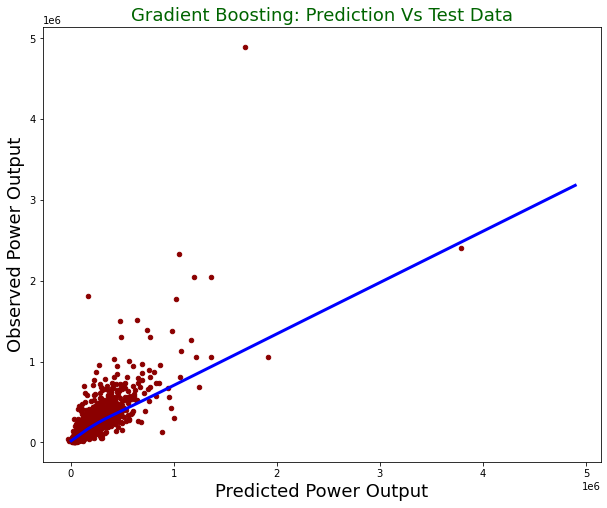

In [188]:
test = pd.DataFrame({"prediction": prediction, "observed": Y_test})

lowess = sm.nonparametric.lowess

z = lowess(prediction, Y_test)


test.plot(figsize = [10,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')

plt.title("Gradient Boosting: Prediction Vs Test Data", fontsize = 18, color = "darkgreen")

plt.xlabel("Predicted Power Output", fontsize = 18) 

plt.ylabel("Observed Power Output", fontsize = 18)

plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)

plt.show()

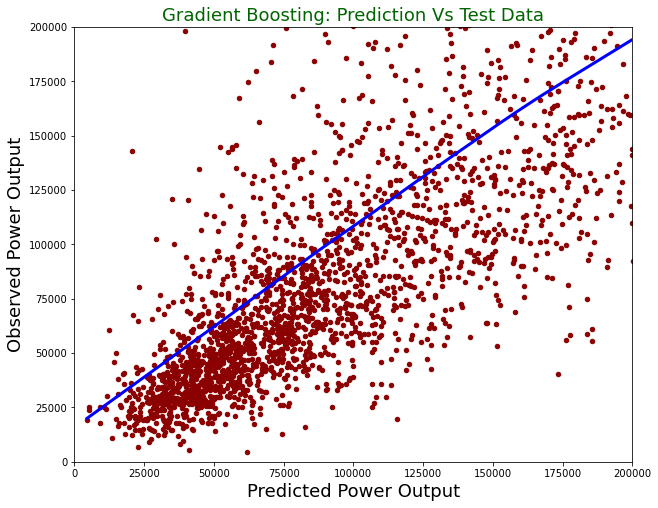

In [189]:
#Hacemos un Zoom
test = pd.DataFrame({"prediction": prediction, "observed": Y_test})
lowess = sm.nonparametric.lowess
z = lowess(prediction, Y_test)

test.plot(figsize = [10,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')

plt.title("Gradient Boosting: Prediction Vs Test Data", fontsize = 18, color = "darkgreen")

plt.xlabel("Predicted Power Output", fontsize = 18) 
plt.xlim(0,200000)
plt.ylabel("Observed Power Output", fontsize = 18)
plt.ylim(0,200000)
plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)

plt.show()

C:\Users\pirosant\Anaconda3\envs\dhdsblend2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 200000.0)

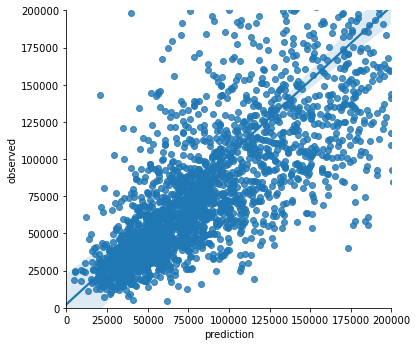

In [190]:
test = pd.DataFrame({"prediction": prediction, "observed": Y_test})

from seaborn import lmplot
lmplot('prediction', 'observed', data=test, fit_reg=True)
plt.xlim(0,200000)
plt.ylim(0,200000)

##### XGBoost

In [191]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [192]:
DM_train = xgb.DMatrix(data = X_train, label = Y_train)
 
DM_test =  xgb.DMatrix(data = X_test, label = Y_test)

In [284]:
gbm_param_grid = {
     'colsample_bytree': np.linspace(0.3, 1, 5),
     'n_estimators':[500, 600],
     'max_depth': [3, 5]
}

In [285]:
gbm = xgb.XGBRegressor()

In [286]:
grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)

In [287]:
grid_mse.fit(X_train, Y_train)

print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.1min finished


Best parameters found:  {'colsample_bytree': 0.6499999999999999, 'max_depth': 3, 'n_estimators': 600}
Lowest RMSE found:  91086.44213244406


In [209]:
pred = grid_mse.predict(X_test)

print("Root mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(Y_test, pred)), 2)))

Root mean square error for test dataset: 111820.96


In [210]:
r2_score(Y_test, pred).round(3)

0.688

In [ ]:
compara_XGB = pd.DataFrame({'Test':Y_test, 'Prediccion':prediction})
compara_XGB.head(10).round(2)

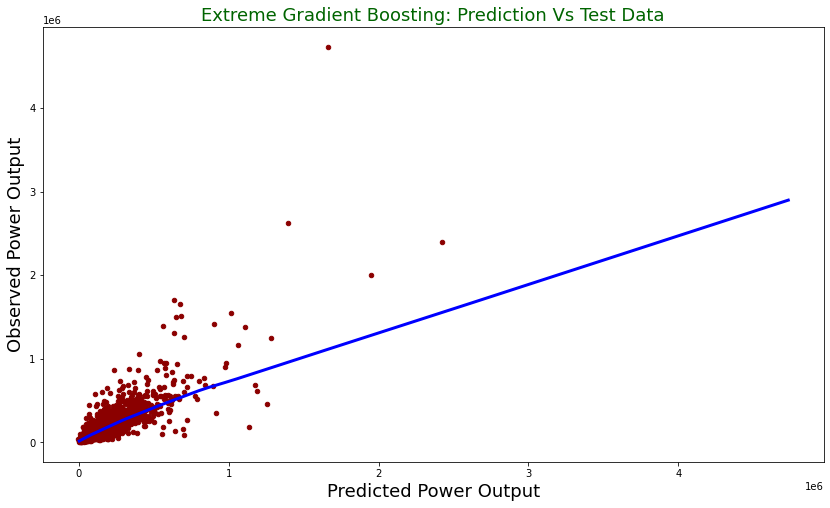

In [176]:
test = pd.DataFrame({"prediction": pred, "observed": Y_test})

lowess = sm.nonparametric.lowess

z = lowess(pred, Y_test)


test.plot(figsize = [14,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')

plt.title("Extreme Gradient Boosting: Prediction Vs Test Data", fontsize = 18, color = "darkgreen")

plt.xlabel("Predicted Power Output", fontsize = 18) 

plt.ylabel("Observed Power Output", fontsize = 18)

plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)

plt.show()

##### REPETICION DE MODELOS QUITANDO VARIABLES EXPLICATIVAS

Habiendo probado todos los modelos, quitaremos las variables explicativas que según statsmodel no son significativas.

In [177]:
data_final.columns.tolist()

['ID_Tasacion',
 'cantidad_CHAPA',
 'cantidad_MECANICA',
 'cantidad_OTROS',
 'cantidad_PINTURA',
 'cantidad_TAPICERIA',
 'desvio_CHAPA',
 'desvio_MECANICA',
 'desvio_OTROS',
 'desvio_PINTURA',
 'desvio_TAPICERIA',
 'UOP__1',
 'UOP__2',
 'UOP__3',
 'SUO__101',
 'SUO__103',
 'SUO__104',
 'SUO__105',
 'SUO__106',
 'SUO__107',
 'SUO__109',
 'SUO__110',
 'SUO__119',
 'SUO__201',
 'SUO__205',
 'SUO__209',
 'SUO__214',
 'SUO__216',
 'SUO__218',
 'SUO__220',
 'SUO__225',
 'SUO__229',
 'SUO__230',
 'SUO__231',
 'SUO__232',
 'SUO__233',
 'SUO__234',
 'SUO__237',
 'SUO__238',
 'SUO__239',
 'SUO__240',
 'SUO__241',
 'SUO__242',
 'SUO__243',
 'SUO__244',
 'SUO__245',
 'SUO__246',
 'SUO__247',
 'SUO__302',
 'SUO__304',
 'SUO__307',
 'SUO__308',
 'SUO__312',
 'SUO__316',
 'SUO__338',
 'SUO__343',
 'SUO__345',
 'SUO__350',
 'SUO__351',
 'SUO__363',
 'SUO__366',
 'SUO__367',
 'SUO__372',
 'SUO__374',
 'SUO__378',
 'SUO__384',
 'SUO__386',
 'SUO__388',
 'SUO__390',
 'SUO__392',
 'SUO__397',
 'SUO__399',

In [178]:
data_final_new = data_final.drop(['SUO__101',
 'SUO__103',
 'SUO__104',
 'SUO__105',
 'SUO__106',
 'SUO__107',
 'SUO__109',
 'SUO__110',
 'SUO__119',
 'SUO__201',
 'SUO__205',
 'SUO__209',
 'SUO__214',
 'SUO__216',
 'SUO__218',
 'SUO__220',
 'SUO__225',
 'SUO__229',
 'SUO__230',
 'SUO__231',
 'SUO__232',
 'SUO__233',
 'SUO__234',
 'SUO__237',
 'SUO__238',
 'SUO__239',
 'SUO__240',
 'SUO__241',
 'SUO__242',
 'SUO__243',
 'SUO__244',
 'SUO__245',
 'SUO__246',
 'SUO__247',
 'SUO__302',
 'SUO__304',
 'SUO__307',
 'SUO__308',
 'SUO__312',
 'SUO__316',
 'SUO__338',
 'SUO__343',
 'SUO__345',
 'SUO__350',
 'SUO__351',
 'SUO__363',
 'SUO__366',
 'SUO__367',
 'SUO__372',
 'SUO__374',
 'SUO__378',
 'SUO__384',
 'SUO__386',
 'SUO__388',
 'SUO__390',
 'SUO__392',
 'SUO__397',
 'SUO__399',
 'anio__1992',
 'anio__1996',
 'anio__1997',
 'anio__1998',
 'anio__1999',
 'anio__2000',
 'anio__2001',
 'anio__2002',
 'anio__2003',
 'anio__2004',
 'anio__2005',
 'anio__2006',
 'anio__2007',
 'anio__2008',
 'anio__2009',
 'anio__2010',
 'anio__2011',
 'anio__2012',
 'anio__2013',
 'anio__2014',
 'anio__2015',
 'anio__2016',
 'anio__2017',
 'anio__2018',
 'anio__2019',
 'anio__2020',
 'anio__2021'],axis=1)
data_final_new.head()

,ID_Tasacion,cantidad_CHAPA,cantidad_MECANICA,cantidad_OTROS,cantidad_PINTURA,cantidad_TAPICERIA,desvio_CHAPA,desvio_MECANICA,desvio_OTROS,desvio_PINTURA,desvio_TAPICERIA,UOP__1,UOP__2,UOP__3,resultado__INDEMNIZAR,resultado__INDEMNIZAR-MANO-OBRA,resultado__REPARAR,resultado__REPARAR-SIN-REPUESTOS,tipo__4X4,tipo__AUTO,tipo__CAMION,tipo__PICKUP,tipo__SEMI-ACOPL,marca__ALFA ROMEO,marca__AUDI,marca__BMW,marca__CHERY,marca__CHEVROLET,marca__CHRYSLER,marca__CITROEN,marca__DFSK,marca__DODGE,marca__DS AUTIMOV,marca__FIAT,marca__FORD,marca__GEELY,marca__GREAT WALL,marca__HAVAL,marca__HINO,marca__HONDA,marca__HYUNDAI,marca__IVECO,marca__JAGUAR,marca__KIA,marca__LAND ROVER,marca__LIFAN,marca__MERC.BENZ,marca__MINICOOPER,marca__MITSUBISHI,marca__NISSAN,marca__PEUGEOT,marca__PORSCHE,marca__RENAULT,marca__SALTO,marca__SCANIA,marca__SMART,marca__SUBARU,marca__SUZUKI,marca__TOYOTA,marca__VOLKSWAGEN,marca__VOLVO,Q_repuestos_calidad_1_C1,Q_repuestos_calidad_1_C2,Q_repuestos_calidad_1_C3,Q_repuestos_calidad_1_C4,Q_repuestos_calidad_2_C1,Q_repuestos_calidad_2_C2,Q_repuestos_calidad_2_C3,Q_repuestos_calidad_2_C4,Q_repuestos_calidad_3_C1,Q_repuestos_calidad_3_C2,Q_repuestos_calidad_3_C3,Q_repuestos_calidad_3_C4,Q_repuestos_calidad_4_C1,Q_repuestos_calidad_4_C2,Q_repuestos_calidad_4_C3,Q_repuestos_calidad_4_C4,compulsa_N,compulsa_S,Q_repuestos_REPARAR_C1,Q_repuestos_REPARAR_C2,Q_repuestos_REPARAR_C3,Q_repuestos_REPARAR_C4,total,neto,suma,total_SA,neto_SA
0,4819,6.0,0.0,1.0,6.5,0.0,0.0,0,0,0.0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,214520.00,196520.00,907500.0,0.236386,0.216551
1,4820,0.5,0.0,0.0,0.5,0.0,0.0,0,0,0.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,36580.04,28580.04,1460000.0,0.025055,0.019575
2,4821,3.5,0.0,0.0,4.0,0.0,-0.5,0,0,-0.5,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,74133.95,62133.95,775500.0,0.095595,0.080121
3,4823,4.0,0.0,0.0,3.0,0.0,-1.5,0,0,-2.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,63929.72,39929.72,1213800.0,0.052669,0.032896
4,4827,0.0,0.0,0.0,2.0,0.0,0.0,0,0,-7.0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,35998.00,35998.00,517000.0,0.069629,0.069629


In [179]:
data_final_new.shape

(11681, 88)

In [180]:
feature_cols = data_final_new.drop(['ID_Tasacion','total','neto','total_SA','neto_SA'], axis = 1)
X = feature_cols
Y = data_final.total

In [181]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=123)

##### Stats model

In [182]:
import statsmodels.api as sm

X_sm = X_train
y_sm = Y_train

# Tenemos que agregar explícitamente a una constante:
X_sm = sm.add_constant(X_sm)

model = sm.OLS(y_sm, X_sm).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     246.4
Date:                Sun, 05 Sep 2021   Prob (F-statistic):               0.00
Time:                        21:58:50   Log-Likelihood:            -1.1323e+05
No. Observations:                8760   AIC:                         2.266e+05
Df Residuals:                    8689   BIC:                         2.271e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

La quita de variables explicativas no tuvo impacto en el R2

##### Regresion Lineal

In [183]:
n = len(Y_test)
k = len(X_test.columns)

In [184]:
# Regresion Lineal
lin_model = linear_model.LinearRegression()
lin_model.fit(X_train, Y_train)
r2_score_linear = lin_model.score(X_train, Y_train)
r2_score_linear_test = lin_model.score(X_test, Y_test)
r2_ajust_linear = 1 - (1 - r2_score_linear_test)*((n-1)/(n - k - 1))
Y_pred_test = lin_model.predict(X_test)
RMSE_linear = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test))

df_resultados = pd.DataFrame(columns=['Model', 'R^2 train', 'R^2 test', 'Alpha', 'R^2_ajust', 'RMSE'])

# Agregamos los resultados al dataframe de resultados
row = {'Model':'Linear Regression', 'R^2 train': r2_score_linear, 'R^2 test': r2_score_linear_test, 'Alpha': 0, 'R^2_ajust': r2_ajust_linear, 'RMSE': RMSE_linear}
df_resultados = df_resultados.append(row, ignore_index=True)

# Ridge (con cross validation de 5 folds)
ridge_model = linear_model.RidgeCV(alphas=np.linspace(0.01,10,100),cv=5, normalize=True)
ridge_model_fitted = ridge_model.fit(X_train, Y_train)
r2_score_ridge = ridge_model_fitted.score(X_train, Y_train)
r2_score_ridge_test = ridge_model_fitted.score(X_test, Y_test)
r2_ajust_ridge = 1 - (1 - r2_score_ridge_test)*((n-1)/(n - k - 1))
Y_pred_test_ridge = ridge_model.predict(X_test)
RMSE_ridge = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test_ridge))

# Agregamos los resultados de Ridge al dataframe de resultados
row = {'Model':'Ridge',  'R^2 train': r2_score_ridge, 'R^2 test': r2_score_ridge_test,  'Alpha': ridge_model_fitted.alpha_, 'R^2_ajust': r2_ajust_ridge, 'RMSE': RMSE_ridge}
df_resultados = df_resultados.append(row, ignore_index=True)

# Lasso (con cross validation de 5 folds)
lasso_model = linear_model.LassoCV(alphas=np.linspace(0.01,10,100),cv=5, normalize=True)
lasso_model_fitted = lasso_model.fit(X_train,Y_train)
r2_score_lasso = lasso_model_fitted.score(X_train, Y_train)
r2_score_lasso_test = lasso_model_fitted.score(X_test, Y_test)
r2_ajust_lasso = 1 - (1 - r2_score_lasso_test)*((n-1)/(n - k - 1))
Y_pred_test_lasso = lasso_model.predict(X_test)
RMSE_lasso = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test_lasso))

# Agregamos los resultados de Lasso al dataframe de resultados
row = {'Model':'Lasso',  'R^2 train': r2_score_lasso, 'R^2 test':r2_score_lasso_test, 'Alpha': lasso_model_fitted.alpha_, 'R^2_ajust': r2_ajust_lasso, 'RMSE': RMSE_lasso}
df_resultados = df_resultados.append(row, ignore_index=True)

# Mostramos los resultados
df_resultados

,Model,R^2 train,R^2 test,Alpha,R^2_ajust,RMSE
0,Linear Regression,0.665005,0.269177,0,0.247796,164957.675984
1,Ridge,0.654862,0.328087,0.211818,0.308429,158169.553443
2,Lasso,0.662172,0.263831,10,0.242293,165559.917727


###### Random Forest

In [185]:
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)

X_test_scl = scaler.transform(X_test)

In [262]:
random_forest = RandomForestRegressor(n_estimators=1000, 
                                      criterion='mse',
                                      max_features='auto',
                                      max_depth = None, 
                                      bootstrap=True, 
                                      n_jobs = -1, 
                                      random_state = 127,
                                      max_samples= 0.3)

In [263]:
random_forest.fit(X_train_scl, Y_train)

RandomForestRegressor(max_samples=0.3, n_estimators=1000, n_jobs=-1,
                      random_state=127)

In [264]:
prediction = random_forest.predict(X_test_scl)
performance = mean_squared_error(Y_test, prediction)
print('MSE:',performance.round(2))
print('RMSE:', np.sqrt(performance).round(2))

MSE: 17059442715.53
RMSE: 130611.8


In [265]:
from sklearn.metrics import r2_score
r2_score(Y_test, prediction).round(3)

0.575

In [268]:
compara_RF = pd.DataFrame({'Test':Y_test, 'Prediccion':prediction})
compara_RF.head(10)

,Test,Prediccion
3432,46000.00,54724.082080
8135,134810.77,227130.297320
1050,31999.44,52033.228565
10180,63000.00,59762.236160
2602,193308.50,159028.575120
253,20000.00,15856.315580
2701,23925.00,33929.659300
11168,30000.00,32280.660120
5830,63000.00,77041.227150
2860,409091.82,216376.816660


##### Extra Trees

In [190]:
extra_tree = ExtraTreesRegressor(n_estimators = 1000,
                                 criterion = 'mse', 
                                 max_depth = None, 
                                 bootstrap = True, 
                                 n_jobs = -1, 
                                 random_state = 171,
                                 max_samples = 0.3)

In [191]:
extra_tree.fit(X_train_scl, Y_train)

ExtraTreesRegressor(bootstrap=True, max_samples=0.3, n_estimators=1000,
                    n_jobs=-1, random_state=171)

In [192]:
prediction = extra_tree.predict(X_test_scl)
performance = mean_squared_error(Y_test, prediction)
print('MSE:', performance.round(2))
print('RMSE:', np.sqrt(performance).round(2))

MSE: 15144586320.4
RMSE: 123063.34


In [193]:
r2_score(Y_test, prediction).round(3)

0.593

##### Gradient Boosting

In [276]:
gb_reg = GradientBoostingRegressor(loss = 'ls',
                                    learning_rate = 0.2,
                                    n_estimators=1000, 
                                    subsample = 1,
                                    criterion='mse',
                                    max_depth = 4, 
                                    random_state = 127)

In [277]:
gb_reg.fit(X_train_scl, Y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.2, max_depth=4,
                          n_estimators=1000, random_state=127, subsample=1)

In [278]:
prediction = gb_reg.predict(X_test_scl)
performance = mean_squared_error(Y_test, prediction)
print("MSE: ", performance.round(2))
print("RMSE: ", np.sqrt(performance).round(2))

MSE:  13564868981.79
RMSE:  116468.32


In [279]:
r2_score(Y_test, prediction).round(3)

0.662

In [280]:
gb_reg.feature_importances_

array([4.50954319e-02, 9.45315073e-02, 1.38986350e-01, 1.33601165e-03,
       7.51523791e-03, 0.00000000e+00, 9.16255497e-03, 0.00000000e+00,
       1.41393920e-04, 1.58347124e-03, 5.34711606e-04, 3.88157880e-04,
       2.89705837e-05, 1.59301069e-04, 2.90784693e-04, 3.55166636e-04,
       7.79734053e-05, 6.94724068e-05, 1.68467177e-04, 1.16169341e-05,
       1.04809437e-03, 3.50376586e-03, 1.31675848e-03, 0.00000000e+00,
       1.10417441e-03, 8.20666015e-04, 2.98157305e-03, 1.76684402e-04,
       2.75566352e-04, 8.20183629e-04, 1.30686060e-03, 3.89507184e-04,
       2.25586033e-03, 2.27025207e-04, 1.55622562e-03, 1.10431797e-03,
       8.49818020e-05, 3.32874024e-04, 5.69045440e-05, 4.60475469e-04,
       3.73495553e-07, 1.29996933e-04, 2.02497933e-04, 5.58107267e-04,
       5.84665334e-05, 8.69884660e-05, 1.49890284e-04, 2.89966239e-05,
       6.60293801e-05, 4.06217557e-05, 2.32039256e-04, 1.43013155e-03,
       1.44800942e-04, 2.85163421e-04, 5.89442947e-04, 5.64881135e-06,
      

In [283]:
compara_XGB2 = pd.DataFrame({'Test':Y_test, 'Prediccion':prediction})
compara_XGB2.head(10).round(2)

,Test,Prediccion
3432,46000.00,123829.69
8135,134810.77,310225.30
1050,31999.44,44557.85
10180,63000.00,53782.82
2602,193308.50,176315.33
253,20000.00,12039.80
2701,23925.00,35762.22
11168,30000.00,21601.16
5830,63000.00,57453.51
2860,409091.82,242941.85


##### Conclusiones:

El modelo que mejor performa es el descenso gradiente con una explicacion de la varianza del 70%.

A partir de los datos arrojados por los diferentes modelos predictivos (con la variacion de sus hiperparametros) y el conocimiento del set de datos de origen, se concluye en que es necesario realizar ajustes/mejoras en la carga de la informacion para poder obtener un R2 mayor. Dichas mejoras se detallan en la presentación power point del presente trabajo.